# SECTION A - Introduction

## I. Problem Statement

Our Client is a Property Agents. They are looking to expand into the Iowa property market. We are tasked to predict the prices of houses based on their characteristics. Our client is also interested in understanding what are the important variables that affects house prices to identify the key characteristics.

**Key Questions from Stakeholder:**
1. Do Neighbourhood matter?
2. Do house size matter?
3. Is a certain area of the house more important?
4. How important is the finishing of the houses?
5. Does the age of the house matter?



## II. Methodology

Linear, Lasso and Ridge regression will be developed to predict the sale price. Out of these 3 models, whichever attained a higher R-squared score will be selected as the final prediction model. Root mean square error will be use to evaluate the accuracy of the model fitting to the validation data points.

Model use:
* Linear Regression
* Lasso Regression
* Ridge Regression

Exploratory Data Analysis:
* Recursive Feature Elimination
* Correlation
* Intuition - reading the data dictionary
* Hypothesis Testing
* Chi-Test Squared

Model Evaluation method:
1. R-squared method
2. Root Mean Squared Error

## III. Data Dictionary

The following datasets were used for the project:

1. [`train.csv`](./datasets/train.csv): Train data ([source](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data))
2. [`test.csv`](./dataset/test.csv): Test data ([source](https://www.kaggle.com/competitions/dsi-us-11-project-2-regression-challenge/data))

The following data dictionary was extract:

1. [`DataDocumentation.csv`](./dataset/DataDocumentation.csv): Data dictionary ([source](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt))

# **SECTION 1 - Data Import & Data Cleaning**

### 1.0 Import Libraries

In [102]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm # a module enabling statistical testing, exploration
import plotly.express as px
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, RFE, chi2

### 1.1 Data Import

#### 1.1.1 Import housing train data

In [103]:
# Import data
house_df = pd.read_csv('./datasets/train.csv')
print(house_df.shape)
house_df.head(3)



(2051, 81)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000


In [104]:
house_test_df = pd.read_csv('./datasets/test.csv')
print(house_test_df.shape)
house_test_df.head(3)

(878, 80)


,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New


#### 1.1.2 Import data dictionary to do counter-check on housing data

In [105]:
# Load data dictionary
data_doc_df = pd.read_csv('./datasets/DataDocumentation.csv',header=None)
data_doc_df = data_doc_df.dropna(subset = [0],axis=0).reset_index(drop=True)
data_doc_df = data_doc_df.rename(columns=lambda x: 'Column_{}'.format(int(x)+1))
feature_sdf = data_doc_df
feature_sdf['Column_2'] = feature_sdf['Column_2'].fillna(value='')





In [106]:
# Separate data type and feature name into column 3 and 4
# Nominal data type
index = feature_sdf[feature_sdf['Column_1'].str.contains("Nominal")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Nominal"

index = feature_sdf[feature_sdf['Column_2'].str.contains("Nominal")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Nominal"
feature_sdf[feature_sdf['Column_1'].str.contains("Nominal")][['Column_1','Column_2','Column_3','Column_4']]

# Ordinal data type
index = feature_sdf[feature_sdf['Column_1'].str.contains("Ordinal")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Ordinal"

index = feature_sdf[feature_sdf['Column_2'].str.contains("Ordinal")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Ordinal"
feature_sdf[feature_sdf['Column_1'].str.contains("Ordinal")][['Column_1','Column_2','Column_3','Column_4']]

# Discrete data type
index = feature_sdf[feature_sdf['Column_1'].str.contains("Discrete")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Discrete"

index = feature_sdf[feature_sdf['Column_2'].str.contains("Discrete")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Discrete"
feature_sdf[feature_sdf['Column_1'].str.contains("Discrete")][['Column_1','Column_2','Column_3','Column_4']]

# Continuous data type
index = feature_sdf[feature_sdf['Column_1'].str.contains("Continuous")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Continuous"

index = feature_sdf[feature_sdf['Column_2'].str.contains("Continuous")][['Column_1','Column_2']].index
for value in index:
    feature_sdf.at[value,'Column_3']= feature_sdf.iloc[value]['Column_1'].split(' (')[0]
    feature_sdf.at[value,'Column_4']= "Continuous"
feature_sdf[feature_sdf['Column_1'].str.contains("Continuous")][['Column_1','Column_2','Column_3','Column_4']]

feature_sdf['Column_4'] = feature_sdf['Column_4'].fillna(value=feature_sdf[feature_sdf['Column_4'].isnull()]['Column_1'])
feature_sdf['Column_3'] = feature_sdf['Column_3'].fillna(value='-')
feature_sdf.head()


,Column_1,Column_2,Column_3,Column_4
0,Order (Discrete): Observation number,,Order,Discrete
1,PID (Nominal): Parcel identification number -...,,PID,Nominal
2,MS SubClass (Nominal): Identifies the type of ...,,MS SubClass,Nominal
3,20,1-STORY 1946 & NEWER ALL STYLES,-,20
4,30,1-STORY 1945 & OLDER,-,30


In [107]:
# load data into a dictionary
data_doc_dict = {}
column = ''
datatype = ''
data = []
#count=0
new_data = False
write_data = False
for col1,col2 in feature_sdf[['Column_3','Column_4']].values:
    col2 = col2.strip()
    
    if col2 != 'Nominal' and col2 != 'Discrete' and col2 != 'Continuous'  and col2 != 'Ordinal' and col2 != '' :
        data.append(col2)
    else:
        if len(data) != 0:
            data_doc_dict[previous_col1] = {'datatype': previous_col2, 'data': data}
            previous_col1 = ''
            previous_col2 = ''
            data=[]
            data_doc_dict[col1] = {'datatype':col2, 'data': []}
            previous_col1 = col1
            previous_col2 = col2
        else:
            data_doc_dict[col1] = {'datatype':col2, 'data': []}
            previous_col1 = col1
            previous_col2 = col2
print(data_doc_dict['MS Zoning'])
print(data_doc_dict['Heating'])
print(data_doc_dict['SalePrice'])


{'datatype': 'Nominal', 'data': ['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']}
{'datatype': 'Nominal', 'data': ['Floor', 'GasA', 'GasW', 'Grav', 'OthW', 'Wall']}
{'datatype': 'Continuous', 'data': []}


In [108]:
#get list of keys
def getList(dict):
    return dict.keys()

data_doc_set = set(getList(data_doc_dict))

print(f'Number of key: {len(data_doc_set)}')


Number of key: 83


In [109]:
# Remove void data
del data_doc_dict['-']

data_doc_set = set(getList(data_doc_dict))
print(f'Number of key: {len(data_doc_set)}')

Number of key: 82


In [110]:
# check what data dictionary have that is not in the train data feature
print(f'Data that is found in data dictionary, which is not in train data:\n{list(set(data_doc_set.difference(house_df.columns)))}')
# check what train data feature have that is not in the data dictionary
print(f'\nData that is found in train data, which is not in data dictionary:\n{list(set(house_df.columns.difference(data_doc_set)))}')

Data that is found in data dictionary, which is not in train data:
['TotRmsAbvGrd', 'FireplaceQu', 'Bedroom', 'Exterior 1', 'HeatingQC', 'Sale Condition', 'BsmtFinType 2', 'Order', '3-Ssn Porch', 'KitchenQual', 'Kitchen', 'Exterior 2']

Data that is found in train data, which is not in data dictionary:
['TotRms AbvGrd', 'Fireplace Qu', 'Kitchen Qual', 'Id', 'BsmtFin Type 2', 'Heating QC', '3Ssn Porch', 'Kitchen AbvGr', 'Bedroom AbvGr', 'Exterior 1st', 'Exterior 2nd']


In [111]:
#Rename data dictionary features to match train data
def rename_dict(new, old):
    data_doc_dict[new]=data_doc_dict[old]
    del data_doc_dict[old]
    return

rename_dict('Heating QC','HeatingQC')
rename_dict('Exterior 1st','Exterior 1')
rename_dict('Kitchen Qual','KitchenQual')
rename_dict('Exterior 2nd','Exterior 2')
rename_dict('3Ssn Porch','3-Ssn Porch')
rename_dict('BsmtFin Type 2','BsmtFinType 2')
rename_dict('Fireplace Qu','FireplaceQu')
rename_dict('TotRms AbvGrd', 'TotRmsAbvGrd')
rename_dict('Bedroom AbvGr', 'Bedroom')
rename_dict('Kitchen AbvGr', 'Kitchen')

data_doc_set = set(getList(data_doc_dict))

In [112]:
# Re-check after renaming features
# check what data dictionary have that is not in the train data feature
print(f'Data that is found in data dictionary, which is not in train data:\n{list(set(data_doc_set.difference(house_df.columns)))}')
# check what train data feature have that is not in the data dictionary
print(f'\nData that is found in train data, which is not in data dictionary:\n{list(set(house_df.columns.difference(data_doc_set)))}')

Data that is found in data dictionary, which is not in train data:
['Sale Condition', 'Order']

Data that is found in train data, which is not in data dictionary:
['Id']


In [113]:
# Remove Sale Condition & Order from dictionary
del data_doc_dict['Order']
del data_doc_dict['Sale Condition']

# add Id into data_doc_dict as placeholder
data_doc_dict['Id'] = {'datatype':'','data':[]}

# # Remove Id from train data
# house_df = house_df.drop(columns=['Id'])
# house_test_df = house_test_df.drop(columns=['Id'])

In [114]:
print(f'Train data shape: {house_df.shape}')
print(f'Data dictionary shape: {len(data_doc_dict)}')
data_doc_set = set(getList(data_doc_dict))

# check what data dictionary have that is not in the train data feature
if list(set(data_doc_set.difference(house_df.columns))) == list(set(house_df.columns.difference(data_doc_set))):
    print('Both train data and dictionary have same column number and name')
else:
    print('Different number of columns or name found in')


Train data shape: (2051, 81)
Data dictionary shape: 81
Both train data and dictionary have same column number and name


In [115]:
# Check data unique value matches data dictionary
#house_df.nunique()
non_unique_data_dict = {}
for x in set(getList(data_doc_dict)):
    unique_data = set(data_doc_dict[x]['data'])
    temp_list = []
    for y in house_df[x]:
        if not y in unique_data:
            temp_list.append(y)
    non_unique_data_dict[x] = {'no_of_non_unique': len(set(temp_list))} #'non_unique_data':set(temp_list), 

print(non_unique_data_dict['Low Qual Fin SF'])
print(non_unique_data_dict['Bsmt Half Bath'])
print(non_unique_data_dict['Half Bath'])



{'no_of_non_unique': 31}
{'no_of_non_unique': 5}
{'no_of_non_unique': 3}


In [116]:
# Compare no of unique data, if unique data less than of data dictionary, assume data to be correct
a = list(house_df.columns)
b = list(house_df.nunique())
unique_df = pd.DataFrame(zip(a,b),columns = ['feature','train_data_nunique'])

data_dict_list = []
data_dict_name_list = []
for x in set(getList(data_doc_dict)):
    z = len(set(data_doc_dict[x]['data']))
    data_dict_list.append(z)
    data_dict_name_list.append(x)
# add column into unique df
unique_df = unique_df.merge(pd.DataFrame(zip(data_dict_name_list,data_dict_list),columns = ['feature','data_dict_nunique']),how = 'left')
unique_df


,feature,train_data_nunique,data_dict_nunique
0,Id,2051,0
1,PID,2051,0
2,MS SubClass,16,16
3,MS Zoning,7,8
4,Lot Frontage,118,0
...,...,...,...
76,Misc Val,28,0
77,Mo Sold,12,0
78,Yr Sold,5,0
79,Sale Type,9,10


In [117]:
# Drop row that have 0 value for data_dict_nunique, indicating non ordinal data
# Comment: data_dict_nunique >= to train_data_nunique, assumed to be correct
unique_df = unique_df.loc[(unique_df['data_dict_nunique']!= 0),:]
unique_df


,feature,train_data_nunique,data_dict_nunique
2,MS SubClass,16,16
3,MS Zoning,7,8
6,Street,2,2
7,Alley,2,3
8,Lot Shape,4,4
9,Land Contour,4,4
10,Utilities,3,4
11,Lot Config,5,5
12,Land Slope,3,3
13,Neighborhood,28,28


## 1.2 Missing Value Handling

### 1.2.1 Convert NaN to string for categorical features

In [118]:
# Convert null to NA or None string for specific data

def fill_na(column_value, repalce_value):
    try:
        house_df[column_value] = house_df[column_value].fillna(value=repalce_value)
        house_test_df[column_value] = house_test_df[column_value].fillna(value=repalce_value)
    except:
        print(f'Fail to fill na for column: {column_value}')
    return

fill_na('Pool QC','NA')
fill_na('Fence','NA')
fill_na('Misc Feature','NA')
fill_na('Feature QC','NA')
fill_na('Garage Cond','NA')
fill_na('Garage Qual','NA')
fill_na('Garage Finish','NA')
fill_na('Alley','NA')
fill_na('Mas Vnr Type','None')
fill_na('Bsmt Cond','NA')
fill_na('Bsmt Exposure','NA')
fill_na('BsmtFin Type 1','NA')
fill_na('BsmtFin Type 2','NA')
fill_na('Fireplace Qu','NA')
fill_na('Garage Type','NA')
fill_na('Bsmt Qual','NA')
print(house_df.isnull().sum().sort_values(ascending=False).head(10))


Fail to fill na for column: Feature QC
Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64


In [119]:
# Garage Yr Blt with null signifies no garage
# However, we cannot set the yr to 0, therefore we decided to drop the column instead
house_df.loc[house_df['Garage Yr Blt'].isnull(),['Garage Finish', 'Garage Area', 'Garage Qual']].shape

(114, 3)

In [120]:
# Check mass vnr area with null values
# Mas Vnr Area with null signifies that it does not have vnr at all
house_df.loc[house_df['Mas Vnr Area'].isnull(),['Mas Vnr Type']].shape

(22, 1)

### 1.2.2 Replace NaN with 0 for numerical features

In [121]:
# Fill na with 0
fill_na('Lot Frontage',0)
fill_na('Bsmt Full Bath',0)
fill_na('Bsmt Half Bath',0)
fill_na('Total Bsmt SF',0)
fill_na('Bsmt Unf SF',0)
fill_na('BsmtFin SF 2',0)
fill_na('Mas Vnr Area',0)
fill_na('BsmtFin SF 1',0)
fill_na('Garage Area',0)
fill_na('Garage Yr Blt',0)
fill_na('Garage Cars',0)

In [122]:
print(house_df.isnull().sum().sort_values(ascending=False).head())

Id              0
Heating QC      0
Garage Type     0
Fireplace Qu    0
Fireplaces      0
dtype: int64


## 1.3 Renaming Dataframe
---

In [123]:
print(house_df.shape)
print(house_test_df.shape)

(2051, 81)
(878, 80)


In [124]:
columns = house_df.columns
columns_list = []
for column in columns:
    columns_list.append(column.lower().replace(' ', '_'))
    data_doc_dict[column.lower().replace(' ', '_')] = data_doc_dict.pop(column)
house_df.columns = columns_list
house_df.columns
data_doc_dict
columns_list.pop()
print(len(columns_list))
house_test_df.columns = columns_list

80


## 1.4 Saving cleaned data

In [125]:
house_df.to_csv('./datasets/train_cleaned.csv', index=False)
house_test_df.to_csv('./datasets/train_cleaned.csv', index=False)

# **SECTION 2 - Exploratory Data Analysis & Feature Engineering** 
---

## 2.0 Create sub-dataframe for manipulation

In [126]:
# any manipulation made will be done on the sub dataframe
house_sdf = house_df
house_test_sdf = house_test_df

### Visual Check

Hist - Saleprice

Comment:

* Positively skewed normal distribution

<AxesSubplot:xlabel='saleprice', ylabel='Count'>

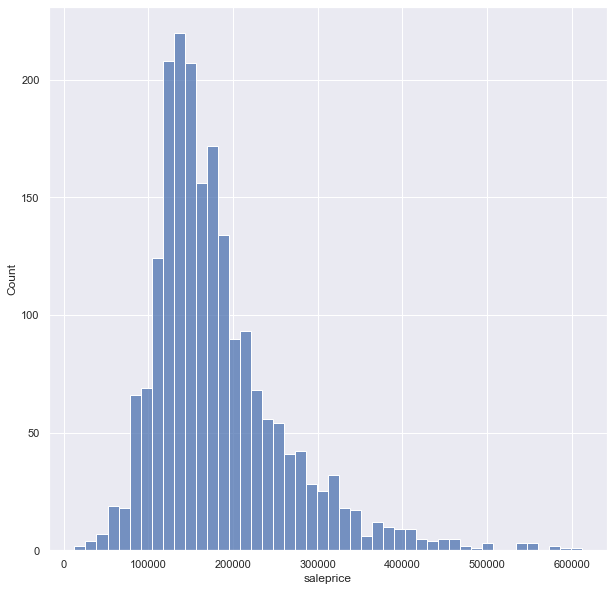

In [127]:
plt.figure(figsize=(10,10))
sns.histplot(data = house_sdf , x='saleprice')

Scat - Year built & Remod/Add against saleprice

Comment:

* All houses that were built before 1950 was remod/add. Houses that are not remod/add will reflect the construction date
* Year Remod/Add will be used to calculate the age of the house instead of year built


<AxesSubplot:xlabel='year_remod/add', ylabel='saleprice'>

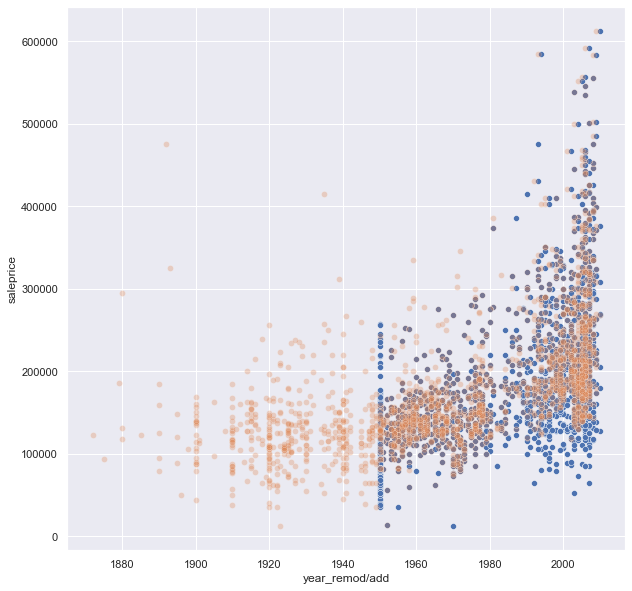

In [128]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = house_sdf , x='year_remod/add',y='saleprice')
sns.scatterplot(data = house_sdf , x='year_built',y='saleprice', alpha = 0.3)

Scat - Year_remod/add & yr_sold against saleprice
Comment: The yr sold shows the sales of the house from 2006 to 2010

<AxesSubplot:xlabel='year_remod/add', ylabel='saleprice'>

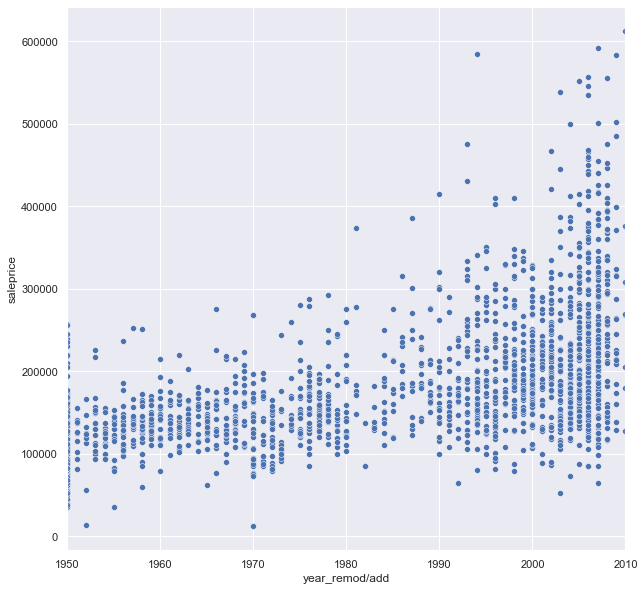

In [129]:
plt.figure(figsize=(10,10))
plt.xlim(left = 1950 , right = 2010)
sns.scatterplot(data = house_sdf , x='year_remod/add',y='saleprice')

Hist - Year sold

Comment:

* Big drop in property sold on 2010, possibly due to the property bubble crash

Text(0.5, 1.0, 'Amount of sale transcation (Yr 2006 to 2010)')

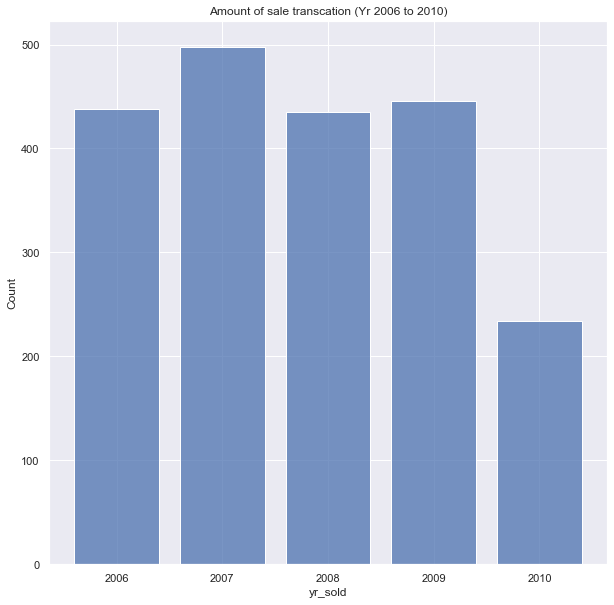

In [130]:
plt.figure(figsize=(10,10))
sns.histplot(data = house_sdf , x='yr_sold', discrete = 'True', shrink = .8)
plt.title('Amount of sale transcation (Yr 2006 to 2010)')

Box - Neighborhood vs Sale price

Comment:

* Different location command different sale price

Text(0.5, 1.0, 'Neighborhood against Saleprice')

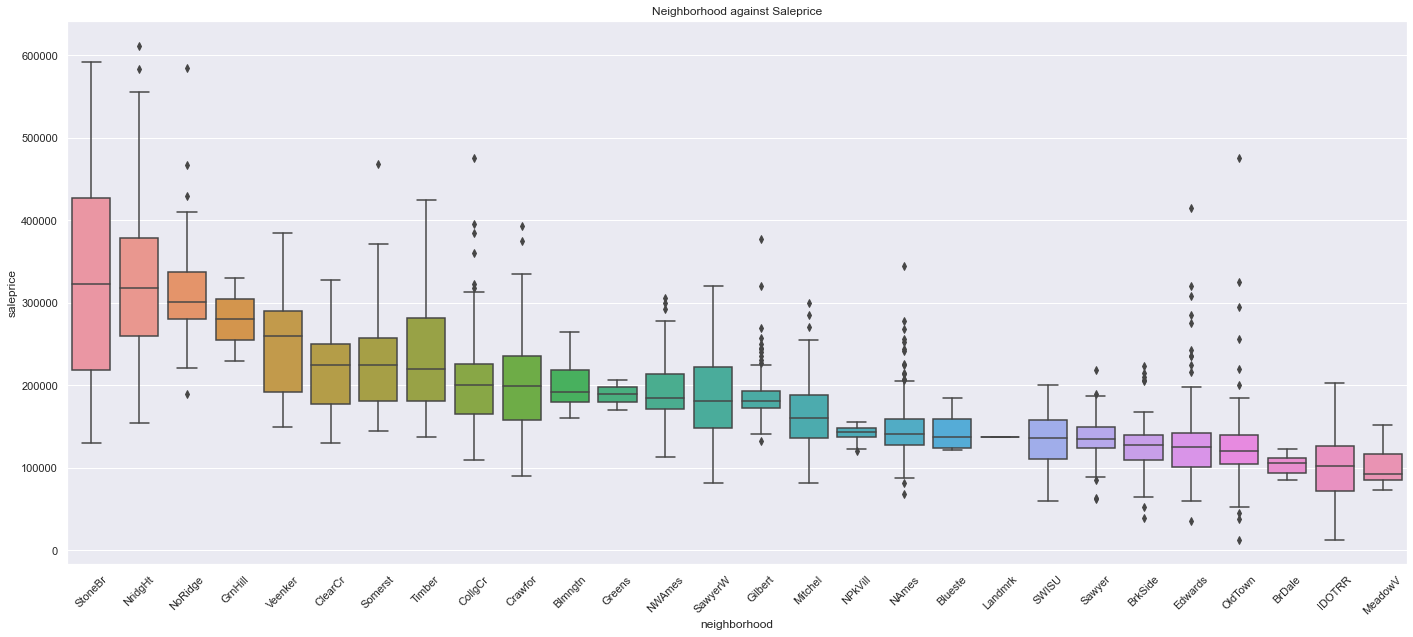

In [131]:
plt.figure(figsize=(24,10))

neighbour_order = house_sdf.groupby(['neighborhood']).median()['saleprice'].sort_values(ascending=False).index

sns.boxplot(x=house_sdf['neighborhood'], y=house_sdf['saleprice'],order = neighbour_order);
plt.xticks(rotation=45)
plt.title("Neighborhood against Saleprice")

## 2.1 Recursive Feature Elimination

Comment: 

* The RFE shows that features that are the main usage of the property has a high relation to the saleprice. This gives us a good indication of what features move the saleprice.

In [132]:
lr = LinearRegression()
rfe1 = RFE(lr, n_features_to_select=10, step=1)
rfe1_sdf = house_sdf.drop(columns=['saleprice'])._get_numeric_data()
selector = rfe1.fit(rfe1_sdf,house_sdf['saleprice'])
selectedFeatures = list(rfe1_sdf.columns[selector.support_])
selectedFeatures

['overall_qual',
 'bsmt_full_bath',
 'bsmt_half_bath',
 'full_bath',
 'half_bath',
 'bedroom_abvgr',
 'kitchen_abvgr',
 'totrms_abvgrd',
 'fireplaces',
 'garage_cars']

### Visual Check

Box - Overall Quality vs Saleprice

Comment:

* Overall quality of the house affects the sale price

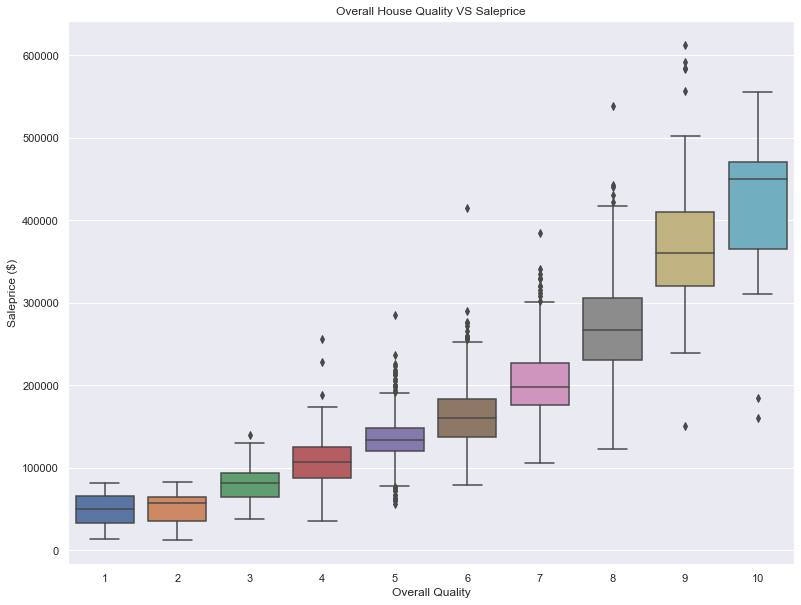

In [133]:
plt.figure(figsize = (13,10))
sns.boxplot(x=house_sdf['overall_qual'],y = house_sdf['saleprice'] )
plt.xlabel('Overall Quality')
plt.ylabel('Saleprice ($)')
plt.title('Overall House Quality VS Saleprice')
plt.show();

Box - Total Rooms above ground against saleprice

Comment: 

* Total Rooms above ground positively affects the sale price, which also reflects the total livable space of the land

Text(0.5, 1.0, 'Total Rooms above Ground (excl. bathroom) VS Saleprice')

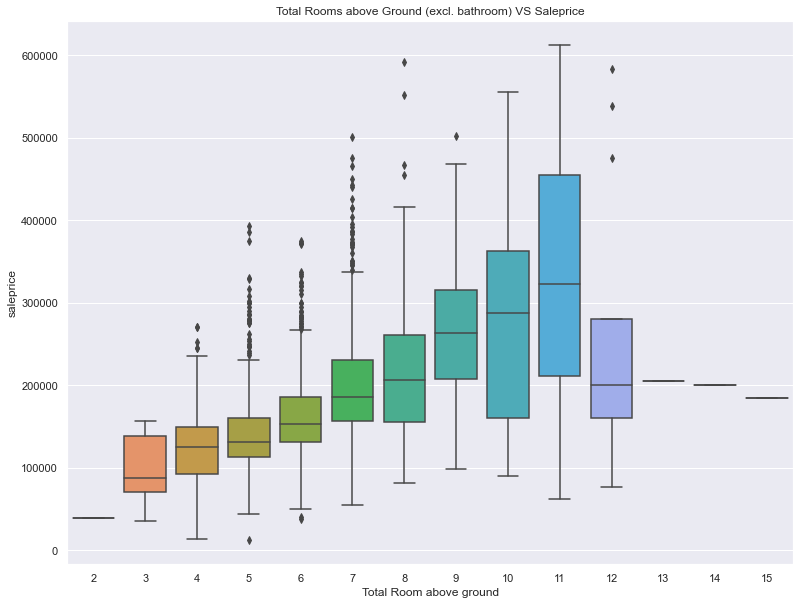

In [134]:
plt.figure(figsize = (13,10))
sns.boxplot(x=house_sdf['totrms_abvgrd'],y = house_sdf['saleprice'] )
plt.xlabel('Total Room above ground')
plt.title('Total Rooms above Ground (excl. bathroom) VS Saleprice')


Box & Hist - Garage cars and area vs Saleprice

Comment:

* Assumed that most people in US owns car. With that assumption, it make sense that the saleprice increases with the garage car capacity as it is demanded.

* With larger garage area, it also means that more cars can be parked.

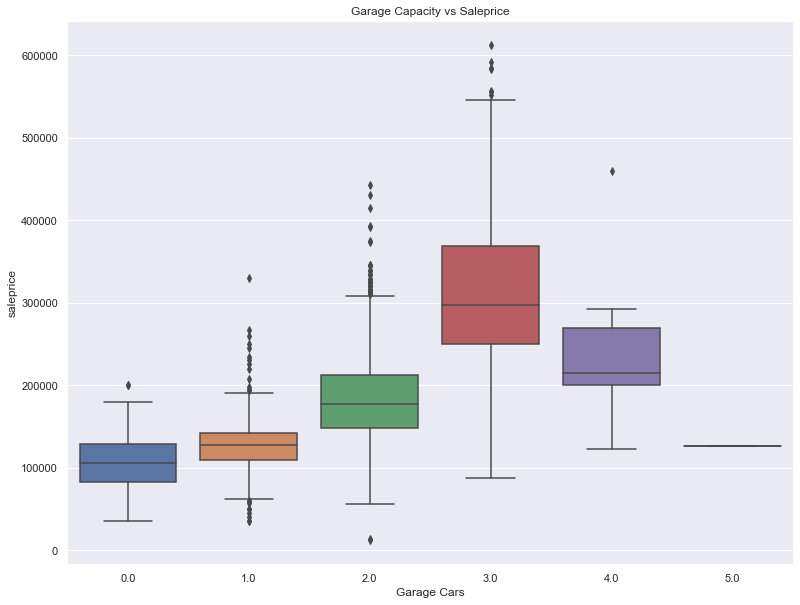

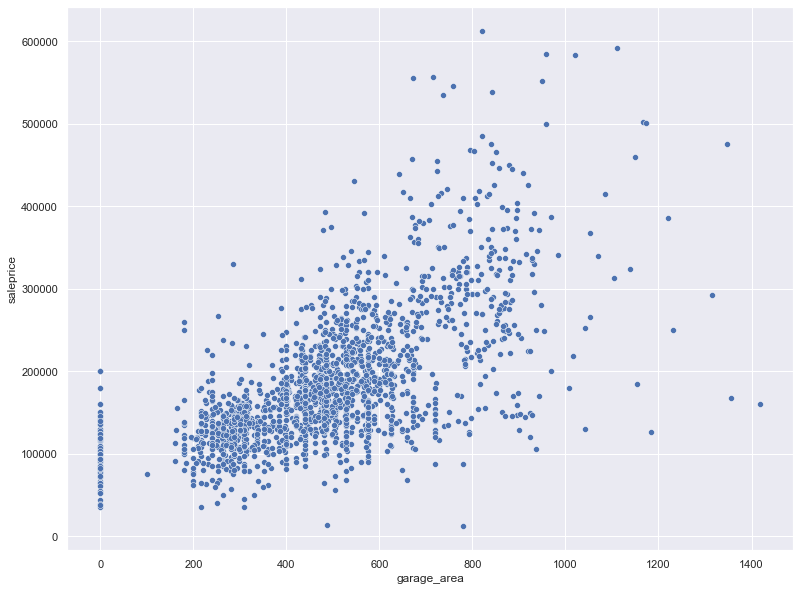

In [135]:
plt.figure(figsize = (13,10))
sns.boxplot(x=house_sdf['garage_cars'],y = house_sdf['saleprice'] )
plt.title('Garage Capacity vs Saleprice')
plt.xlabel('Garage Cars')
plt.show();
plt.figure(figsize = (13,10))
sns.scatterplot(x=house_sdf['garage_area'],y = house_sdf['saleprice'] )
plt.show();

## 2.2 Correlation

Comment: Correlation also tells almost the same story. Overall quality, ground living area and 1st floor area (could be equivalent to the total number of rooms), garage cars and number of bathrooms are similarly shown with the recursive feature elimination.



In [136]:
p_val = house_sdf.corr()['saleprice'].sort_values(ascending=False)

# filtering to top correlated features with pearson coeff > 0.5
p_val_high = p_val[p_val>=0.5]

p_val_high

saleprice         1.000000
overall_qual      0.800207
gr_liv_area       0.697038
garage_area       0.649897
garage_cars       0.647781
total_bsmt_sf     0.629303
1st_flr_sf        0.618486
year_built        0.571849
year_remod/add    0.550370
full_bath         0.537969
totrms_abvgrd     0.504014
mas_vnr_area      0.503579
Name: saleprice, dtype: float64

### Visual Check

Heatmap - Correlation

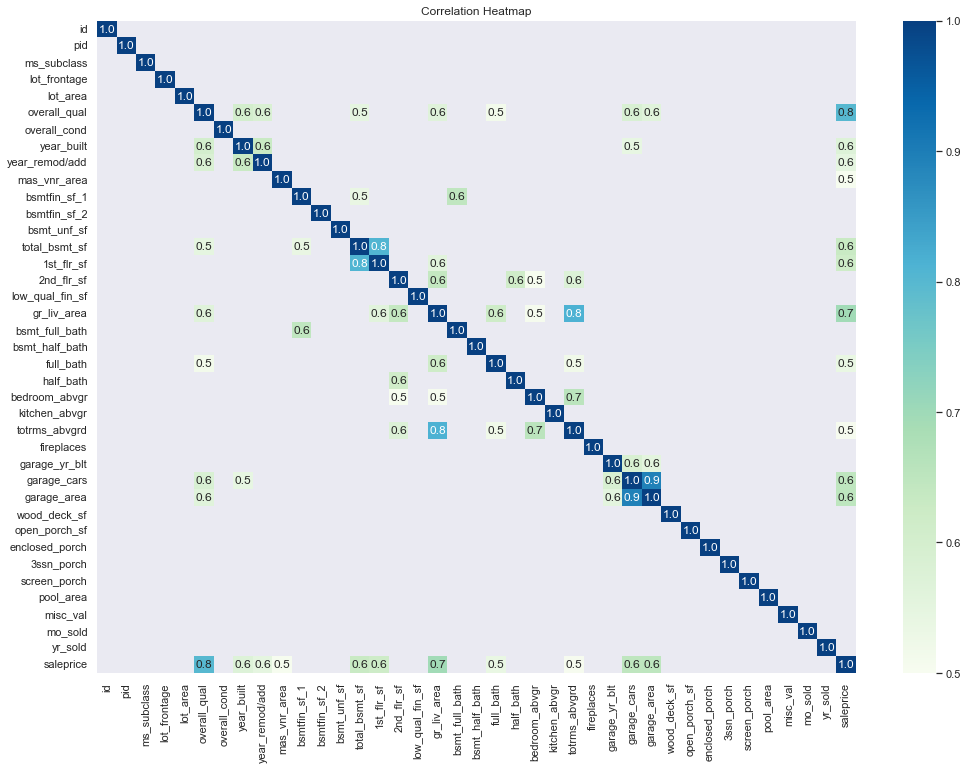

In [137]:
# Plot correlation heatmap
p_corr = house_sdf.corr()
p_corr_high = p_corr[p_corr >= 0.5]

plt.figure(figsize=(17, 12))
sns.heatmap(p_corr_high,
            annot=True,
            fmt='.1f',
            cmap='GnBu',
            vmin=0.5,
            vmax=1)
title = plt.title('Correlation Heatmap')

Heatmap - Correlation (Zoomed)

Comment:

* Garage cars and garage area show multicollinearity, garage cars feature will be drop in favour of garage area as it is a continuous feature

* 1st floor area and total basement area shows multicollinearity also. The floor area will be merged together instead.

* Year built and year remod/add also shows multicollinearity. Year remod/add will be use with year sold to extract the house age instead while year built will be dropped.

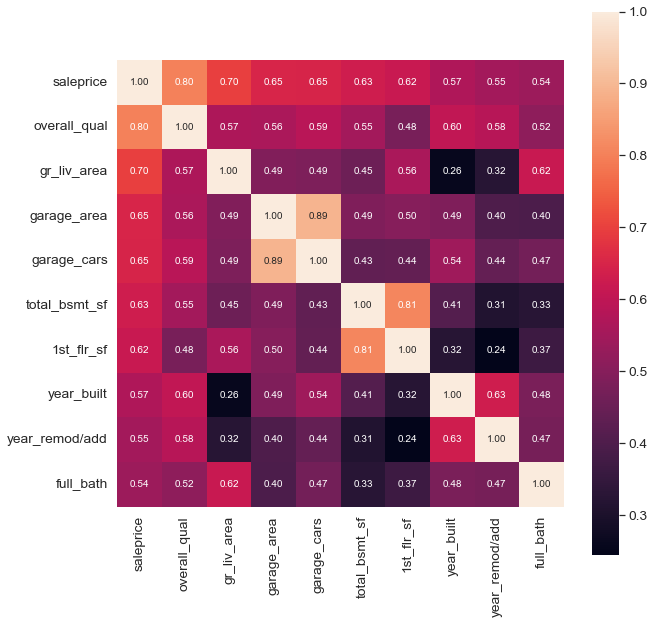

In [138]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = p_corr.nlargest(k, 'saleprice')['saleprice'].index
cm = np.corrcoef(house_sdf[cols].values.T)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Pairplot - Highly correlated features and response

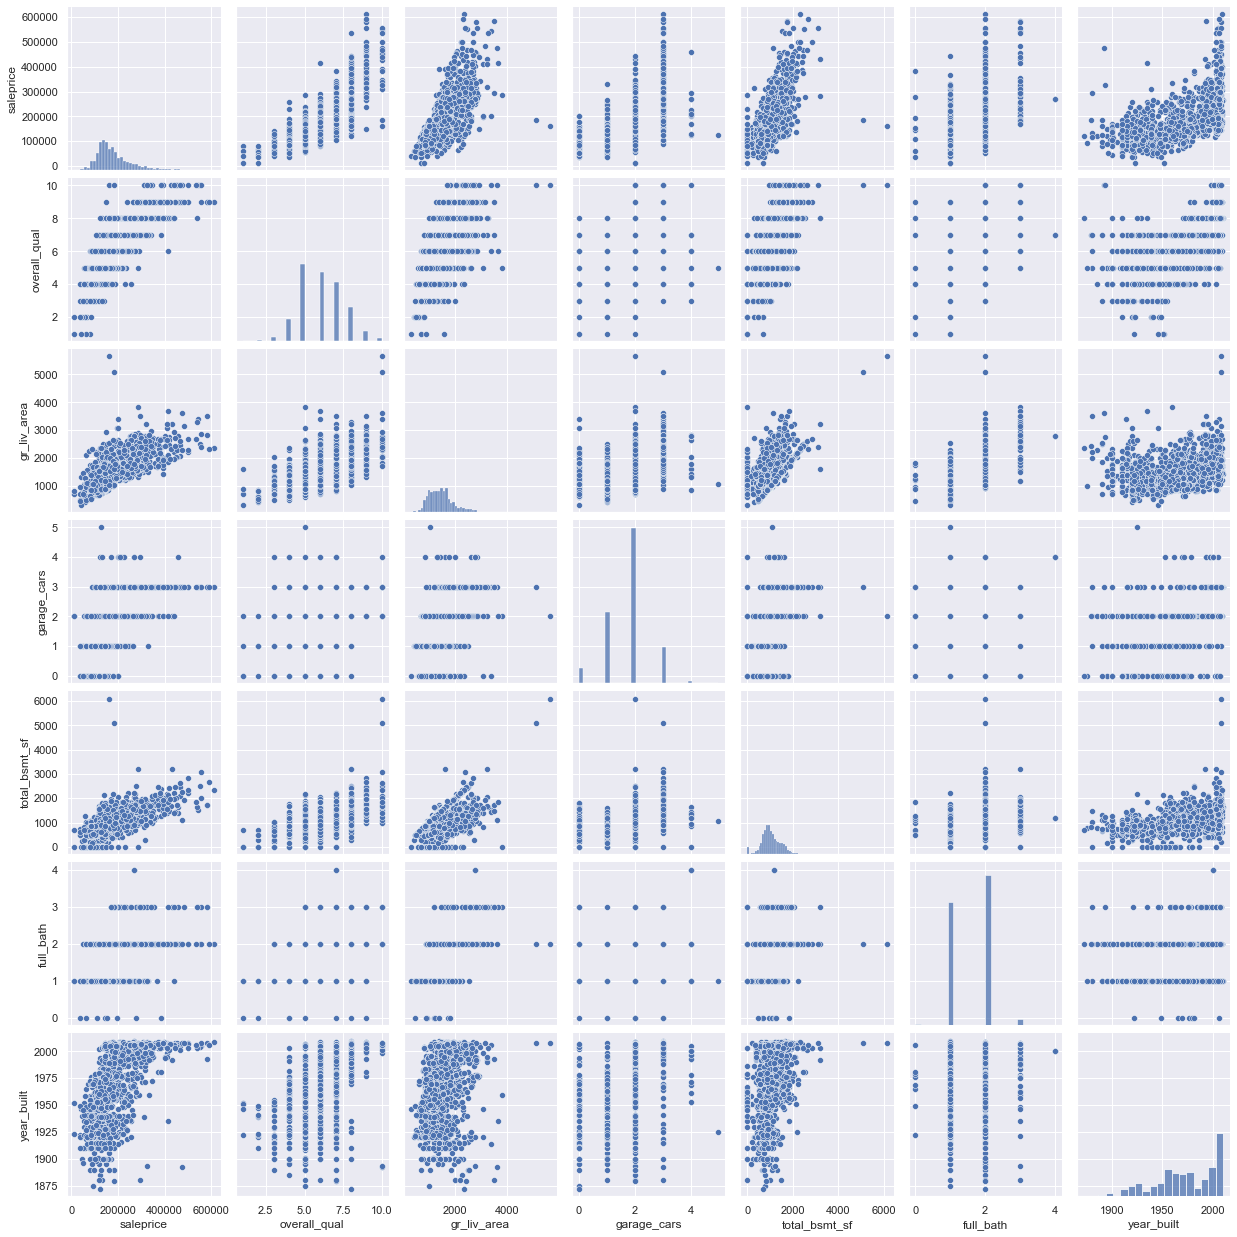

In [139]:
sns.set()
cols = ['saleprice', 'overall_qual', 'gr_liv_area', 'garage_cars', 'total_bsmt_sf', 'full_bath', 'year_built']
sns.pairplot(house_sdf[cols])
plt.show();

Scat - Ground living area vs saleprice

Comment: 

* Ground Living area shows a very positive relation against the sale price

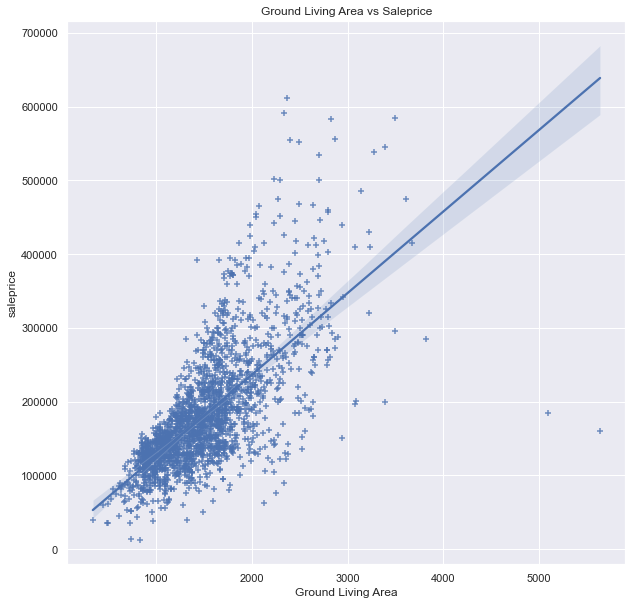

In [140]:
plt.figure(figsize = (10,10))
sns.regplot(x=house_sdf['gr_liv_area'],y = house_sdf['saleprice'],marker='+' )
plt.title('Ground Living Area vs Saleprice')
plt.xlabel('Ground Living Area')
plt.show();

Scat and Box - Masonary veneer area & type vs Saleprice

Comment:

* No clear relation against saleprice

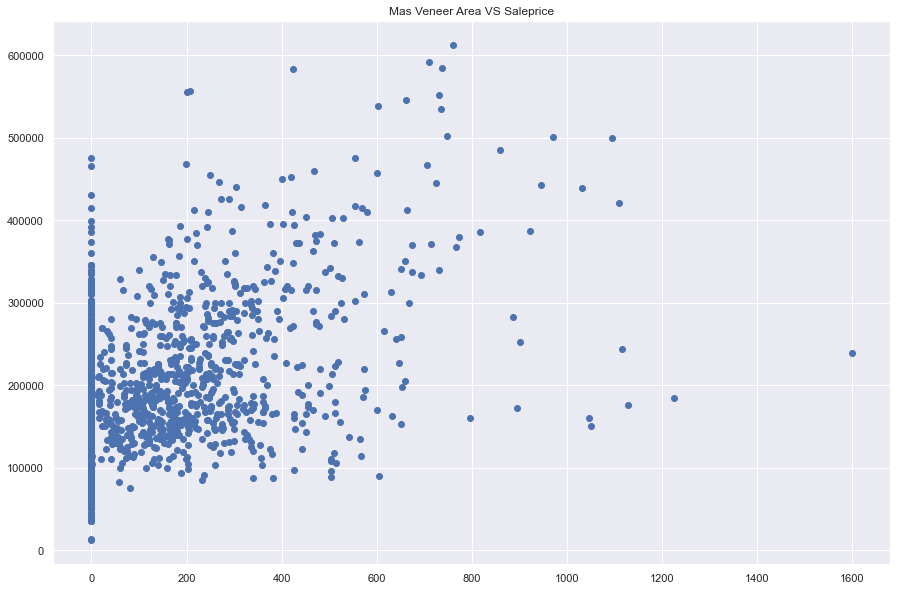

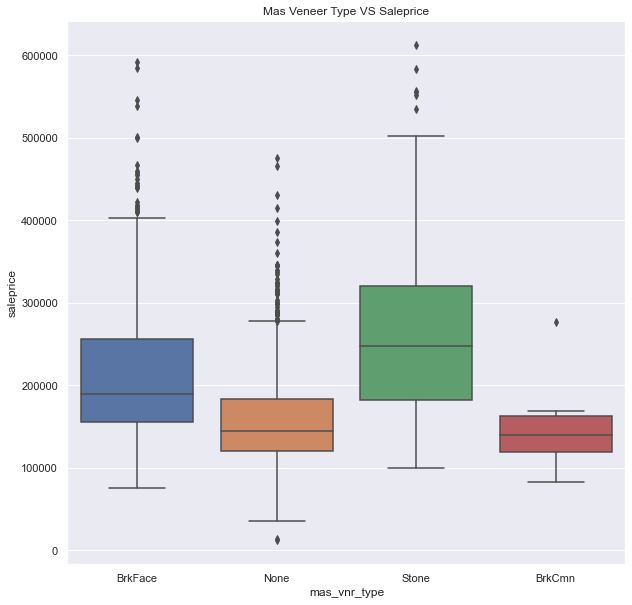

In [141]:
plt.figure(figsize=(15,10))
plt.scatter(data=house_sdf,y='saleprice',x='mas_vnr_area')
plt.title('Mas Veneer Area VS Saleprice')
plt.show();

plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'mas_vnr_type', y = 'saleprice')
plt.title('Mas Veneer Type VS Saleprice')
plt.show();

## 2.3 Outlier

Z-score Method

Comment: Using Z-scores to eliminate outlier reduced too much rows, therefore the method was not included in the cleaning process.

In [142]:
print(house_sdf.shape)
z_scores = zscore(house_sdf._get_numeric_data())
abs_z_scores = np.abs(z_scores)
abs_z_scores.describe(include='all')

filtered_entries = (abs_z_scores <3).all(axis=1)
outlier_removed_sdf = house_sdf[filtered_entries]
outlier_removed_sdf.shape

(2051, 81)


(1372, 81)

Removing outlier from "1st Floor Area" feature

In [143]:
house_sdf[house_sdf['1st_flr_sf']>3500].index

Int64Index([616, 960, 1885], dtype='int64')

### Visual Check

Scat - 1st Floor Area against sale price

Comment:

Outlier was not remove, the removal of the two rows impact the final RMSE by 3000.


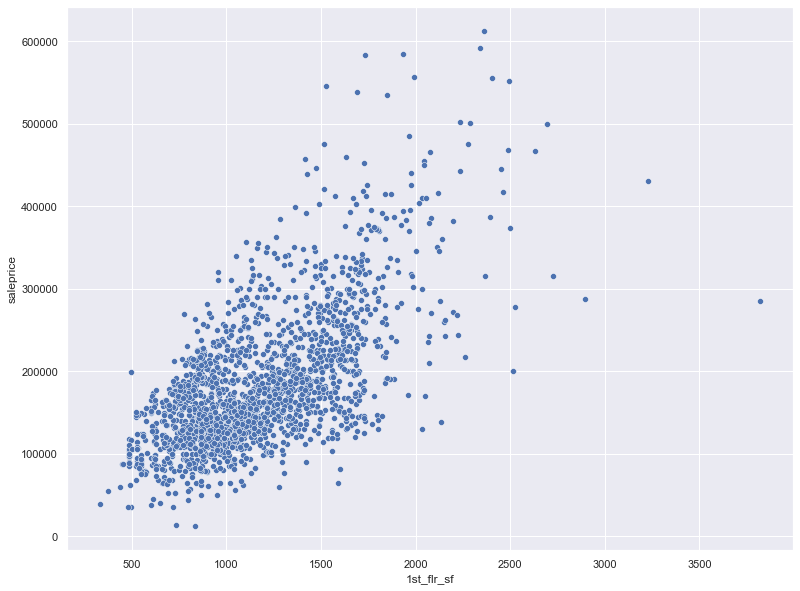

In [144]:
plt.figure(figsize = (13,10))
sns.scatterplot(x=house_sdf.drop([960, 1885])['1st_flr_sf'],y = house_sdf.drop([960, 1885])['saleprice'] )
plt.show();

# plt.figure(figsize = (13,10))
# sns.scatterplot(x=outlier_removed_sdf['1st_flr_sf'],y = house_sdf['saleprice'] )
# plt.show();

## 2.4 Low Variance (Numeric Feature)

Comment: bsmt_half_bath and kitchen_abvgr will not be dropped, will be merged with other columns

In [145]:
numeric_feature = [col for col in house_sdf._get_numeric_data().columns if col != 'saleprice' and col != 'id']
variance_filter_sdf = house_sdf[numeric_feature]
threshold = 0.8
sel = VarianceThreshold(threshold=(threshold*(1-threshold)))
_ =  sel.fit(variance_filter_sdf)
mask = sel.get_support()
variance_filter_reduced_sdf = variance_filter_sdf.loc[:,mask]
variance_filter_reduced_sdf.shape

column_to_drop = list(set(variance_filter_sdf.columns.difference(variance_filter_reduced_sdf.columns)))
print(f'Variance threshold: {threshold}')
print(f'Columns to drop: {column_to_drop}')


Variance threshold: 0.8
Columns to drop: ['kitchen_abvgr', 'bsmt_half_bath']


## 2.5 Low Variance (Categorical Feature)

In [146]:
try:
    mask = house_sdf.describe(include = 'all').T['freq'].sort_values(ascending= False)>1700
    highfreq_house_sdf = house_sdf.loc[:,mask].describe(include = 'all').T.sort_values(['freq'],ascending=False)
    highfreq_house_sdf
except:
    print(f'No data has a low variance')

### Visual Check

Bar - Features with low variance

Comment: 

* Low variance categorical features are dropped except for condition/quality features. These features will be merged to create new features. 

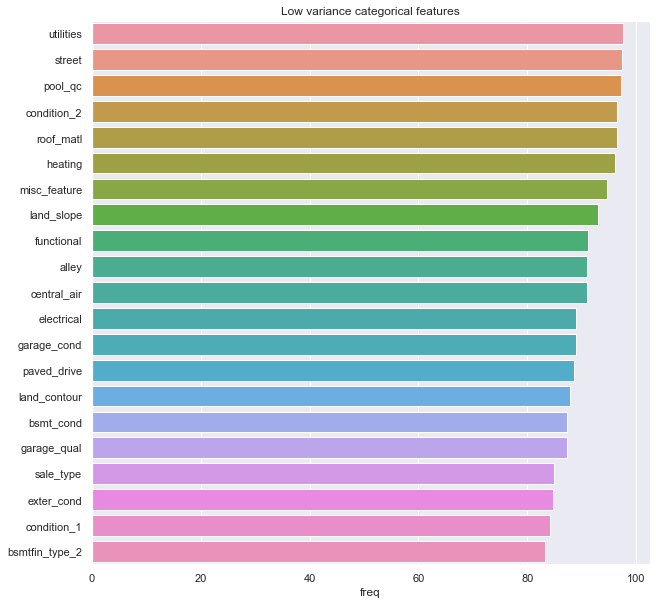

In [147]:
try:
    plt.figure(figsize= (10,10))
    sns.barplot(x = highfreq_house_sdf['freq']/highfreq_house_sdf.shape[0],y = highfreq_house_sdf.index );
    plt.title('Low variance categorical features')
except:
    print(f'No low variance data to show')

## 2.6 Categorical to Ordinal Conversion

In [148]:
ordinal_features = ['Lot Shape',
'House Style',
'Exter Qual',
'Exter Cond',
'Bsmt Qual',
'Bsmt Cond',
'Bsmt Exposure',
'BsmtFin Type 1',
'BsmtFin Type 2',
'Heating QC',
'Kitchen Qual',
'Fireplace Qu',
'Garage Finish',
'Garage Qual',
'Garage Cond']

# replace old name with new naming convention
ordinal_features = [feature.lower().replace(' ', '_') for feature in ordinal_features]

for feature in ordinal_features:
    print(f'Train Ordinal feature ({feature}): {house_sdf[feature].unique()}')
    print(f'Test Ordinal feature ({feature}): {house_test_sdf[feature].unique()}')

Train Ordinal feature (lot_shape): ['IR1' 'Reg' 'IR2' 'IR3']
Test Ordinal feature (lot_shape): ['Reg' 'IR1' 'IR3' 'IR2']
Train Ordinal feature (house_style): ['2Story' '1Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin' '1.5Unf']
Test Ordinal feature (house_style): ['2Story' '1Story' '1.5Fin' 'SLvl' 'SFoyer' '2.5Fin' '2.5Unf' '1.5Unf']
Train Ordinal feature (exter_qual): ['Gd' 'TA' 'Ex' 'Fa']
Test Ordinal feature (exter_qual): ['TA' 'Gd' 'Fa' 'Ex']
Train Ordinal feature (exter_cond): ['TA' 'Gd' 'Fa' 'Ex' 'Po']
Test Ordinal feature (exter_cond): ['Fa' 'TA' 'Gd' 'Ex' 'Po']
Train Ordinal feature (bsmt_qual): ['TA' 'Gd' 'Fa' 'NA' 'Ex' 'Po']
Test Ordinal feature (bsmt_qual): ['Fa' 'Gd' 'TA' 'Ex' 'NA' 'Po']
Train Ordinal feature (bsmt_cond): ['TA' 'Gd' 'NA' 'Fa' 'Po' 'Ex']
Test Ordinal feature (bsmt_cond): ['TA' 'Gd' 'NA' 'Fa']
Train Ordinal feature (bsmt_exposure): ['No' 'Gd' 'Av' 'NA' 'Mn']
Test Ordinal feature (bsmt_exposure): ['No' 'Av' 'NA' 'Mn' 'Gd']
Train Ordinal feature (bsmtfin_type

In [149]:
# Convert feature to ordinal
for feature in ordinal_features:
    print(f'Train data unique value before conversion: {house_sdf[feature].unique()}')
    print(f'Test data unique value before conversion: {house_test_sdf[feature].unique()}')
    data_len = len(data_doc_dict[feature]['data'])-1
    for data in data_doc_dict[feature]['data']:
        house_sdf.loc[(house_sdf[feature]==data),[feature]] = int(data_len)
        house_test_sdf.loc[(house_test_sdf[feature]==data),[feature]] = int(data_len)
        data_len -=1
    house_sdf[feature] = pd.to_numeric(house_sdf[feature]).astype(int)
    house_test_sdf[feature] = pd.to_numeric(house_test_sdf[feature]).astype(int)

    print(feature)
    print(f'Train data unique value: {house_sdf[feature].unique()}')
    print(f'Train data sum of unique value: {house_sdf[feature].unique().sum()}') 
    print(f'Test data unique value: {house_test_sdf[feature].unique()}')
    print(f'Test data sum of unique value: {house_test_sdf[feature].unique().sum()}\n') 
    #print(type(house_df[feature]))  

house_ordinal_sdf = house_sdf[ordinal_features]
house_ordinal_sdf['saleprice'] = house_sdf['saleprice']


Train data unique value before conversion: ['IR1' 'Reg' 'IR2' 'IR3']
Test data unique value before conversion: ['Reg' 'IR1' 'IR3' 'IR2']
lot_shape
Train data unique value: [2 3 1 0]
Train data sum of unique value: 6
Test data unique value: [3 2 0 1]
Test data sum of unique value: 6

Train data unique value before conversion: ['2Story' '1Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin' '1.5Unf']
Test data unique value before conversion: ['2Story' '1Story' '1.5Fin' 'SLvl' 'SFoyer' '2.5Fin' '2.5Unf' '1.5Unf']
house_style
Train data unique value: [4 7 6 1 0 2 3 5]
Train data sum of unique value: 28
Test data unique value: [4 7 6 0 1 3 2 5]
Test data sum of unique value: 28

Train data unique value before conversion: ['Gd' 'TA' 'Ex' 'Fa']
Test data unique value before conversion: ['TA' 'Gd' 'Fa' 'Ex']
exter_qual
Train data unique value: [3 2 4 1]
Train data sum of unique value: 10
Test data unique value: [2 3 1 4]
Test data sum of unique value: 10

Train data unique value before conversion

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1394366063.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Visual Check

Box - Garage finish vs saleprice

Comment:

* Sale price increase with the increase in garage finish

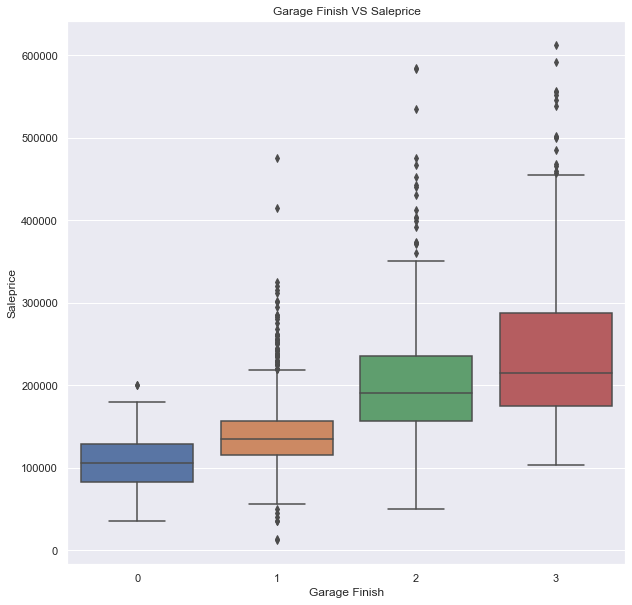

In [150]:
plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'garage_finish', y = 'saleprice')
plt.xlabel('Garage Finish')
plt.ylabel('Saleprice')
plt.title('Garage Finish VS Saleprice')
plt.show()

Box - Fireplace quality vs saleprice

Comment:

Fireplace quality shows an increase in saleprice when it reaches a certain level of quality. Lower quality is able to meets it's requirement, higher quality fireplace is more for affluent buyer.

Text(0.5, 1.0, 'Fireplace quality vs Saleprice')

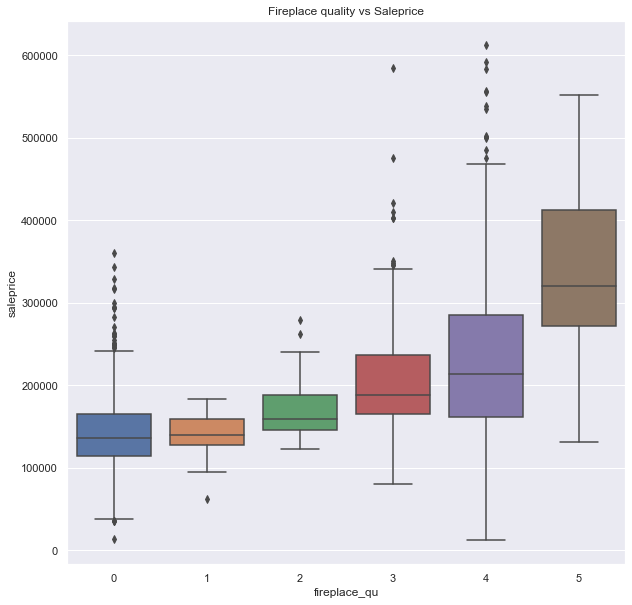

In [151]:
plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'fireplace_qu', y = 'saleprice')
plt.title('Fireplace quality vs Saleprice')

Box - Basement quality vs saleprice

Comment:

Basement quality shows an increase in saleprice when it reaches a certain level of quality.

<AxesSubplot:xlabel='bsmt_qual', ylabel='saleprice'>

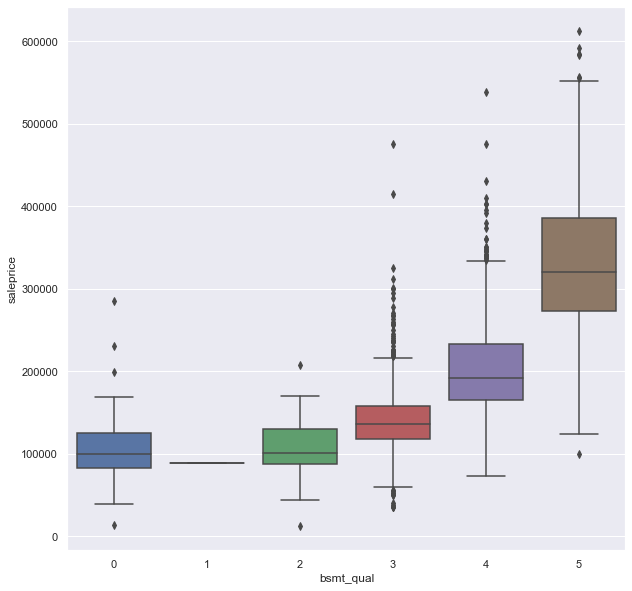

In [152]:
plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'bsmt_qual', y = 'saleprice')

Box - External quality vs saleprice

Comment:

* External quality positively affects the sale price. Higher quality material = higher price

Text(0.5, 1.0, 'External Quality vs Saleprice')

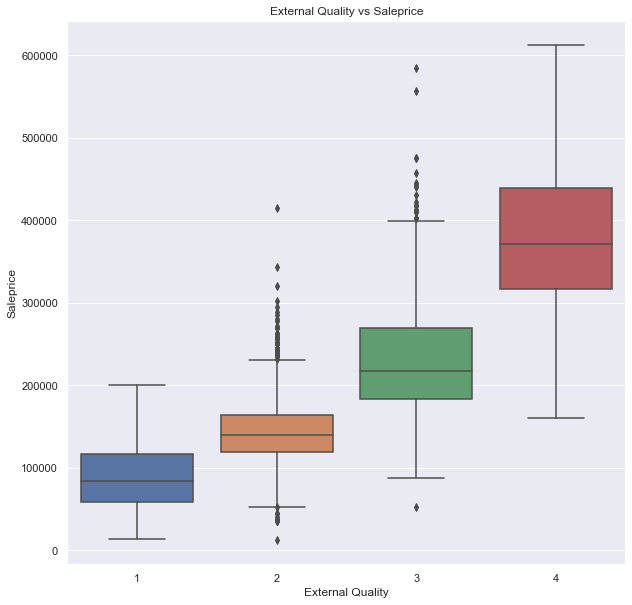

In [153]:
plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'exter_qual', y = 'saleprice')
plt.xlabel('External Quality')
plt.ylabel('Saleprice')
plt.title('External Quality vs Saleprice')


Box - Kitchen quality vs saleprice

Comment:

* Kitchen quality affect the sale price. This is very true as the material to built the kitchen increases with quality

Text(0.5, 0, 'Kitchen Quality')

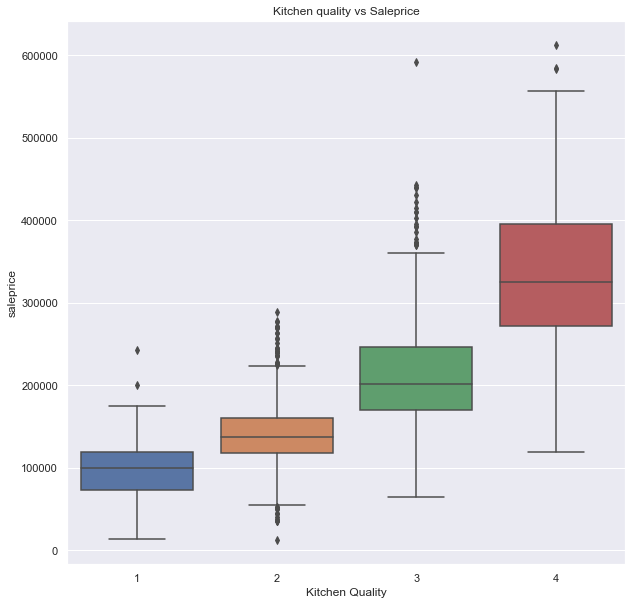

In [154]:
plt.figure(figsize=(10,10))
sns.boxplot(data = house_sdf , x = 'kitchen_qual', y = 'saleprice')
plt.title('Kitchen quality vs Saleprice')
plt.xlabel('Kitchen Quality')

## 2.7 Chi-Square Test

In [155]:
X_chi_sdf = house_ordinal_sdf.drop('saleprice',axis =1)
y_chi_sdf = house_ordinal_sdf['saleprice']

chi_scores = chi2(X_chi_sdf,y_chi_sdf)
chi_scores

(array([ 126.27157311,  550.754202  ,  216.93152185,   54.1757422 ,
         339.64322221,  137.60044584,  801.29100898, 1370.3869671 ,
         571.77972384,  313.74937607,  252.76849733, 2193.27889153,
         614.37178696,  208.56808785,  203.40730372]),
 array([1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
        1.00000000e+000, 1.00000000e+000, 7.33154513e-001, 1.48657926e-029,
        1.00000000e+000, 1.00000000e+000, 1.00000000e+000, 3.49643660e-124,
        9.99999995e-001, 1.00000000e+000, 1.00000000e+000]))

### Visual Check

Bar - P value of Ordinal Features

Comment:

* Most of the features that are above the threshold of 0.05 is regards to the quality and condition of the building. Intuitively, these features are important for a home buyer. Will further analyze by merging the features together.

In [156]:
# top correlated features + p_values visualization from chi-square test
p_values = pd.Series(chi_scores[1],index = X_chi_sdf.columns)
p_values.sort_values(inplace = True)

fig=px.bar(p_values, labels={'value': 'p_value'}, width=600, height=500)
fig.add_hline(y=0.05, line_dash="dash", line_color="red")
fig.update_layout(showlegend=False)
fig.update_xaxes(tickangle = 90)

In [157]:
# top correlated features + p_values converted to dataframe for top features list extraction
cat_pvals_df = pd.DataFrame(p_values, columns=['p_value'])
cat_pvals_df

,p_value
fireplace_qu,3.496437e-124
bsmtfin_type_1,1.486579e-29
bsmt_exposure,7.331545e-01
garage_finish,1.000000e+00
bsmtfin_type_2,1.000000e+00
house_style,1.000000e+00
lot_shape,1.000000e+00
exter_qual,1.000000e+00
exter_cond,1.000000e+00
bsmt_qual,1.000000e+00


## 2.8 Combination of Features
---

In [158]:
def merge_drop_columns(df,sdf):
    df['bsmt_qual*cond'] = df['bsmt_qual'] * df['bsmt_cond']
    df = df.drop(columns=['bsmt_qual','bsmt_cond'])
    sdf['bsmt_qual*cond'] = df['bsmt_qual*cond']
    print(df['bsmt_qual*cond'].sample(2))

    df['bsmtfin_type*sf_1&2'] = df['bsmtfin_type_1']*df['bsmtfin_sf_1'] + df['bsmtfin_type_2']*df['bsmtfin_sf_2'] + df['bsmt_unf_sf']
    df = df.drop(columns=['bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2','bsmt_unf_sf'])
    print(df['bsmtfin_type*sf_1&2'].sample(2))
    sdf['bsmtfin_type*sf_1&2'] = df['bsmtfin_type*sf_1&2']

    df['ttl_flr_sf'] = df['1st_flr_sf'] + df['2nd_flr_sf'] + df['low_qual_fin_sf'] * 0.5
    df = df.drop(columns=['1st_flr_sf','2nd_flr_sf','low_qual_fin_sf'])
    print(df['ttl_flr_sf'].sample(2))
    sdf['ttl_flr_sf'] = df['ttl_flr_sf']

    df['ttl_bath'] = df['bsmt_full_bath'] + df['bsmt_half_bath']*0.5 +df['full_bath'] + df['half_bath']*0.5 
    df = df.drop(columns=['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath'])
    print(df['ttl_bath'].sample(2))
    sdf['ttl_bath'] = df['ttl_bath']

    df['kitchen_ttl_qual'] =  df['kitchen_abvgr'] * df['kitchen_qual']
    df = df.drop(columns=['kitchen_abvgr','kitchen_qual'])
    print(df['kitchen_ttl_qual'].sample(2))
    sdf['kitchen_ttl_qual'] = df['kitchen_ttl_qual']

    df['fireplace_ttl_qual'] =  df['fireplaces'] * df['fireplace_qu']
    df = df.drop(columns=['fireplaces','fireplace_qu'])
    print(df['fireplace_ttl_qual'].sample(2))
    sdf['fireplace_ttl_qual'] = df['fireplace_ttl_qual']

    df['porch_ttl_sf'] =  df['wood_deck_sf'] + df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch']
    df = df.drop(columns=['wood_deck_sf','open_porch_sf','enclosed_porch','3ssn_porch','screen_porch'])
    print(df['porch_ttl_sf'].sample(2))
    sdf['porch_ttl_sf'] = df['porch_ttl_sf']

    #additional changes
    df['overall_qual*cond'] =  df['overall_qual'] * df['overall_cond']
    df = df.drop(columns=['overall_qual','overall_cond'])
    print(df['overall_qual*cond'].sample(2))
    sdf['overall_qual*cond'] =df['overall_qual*cond']

    df['ext_qual*cond'] =  df['exter_qual'] * df['exter_cond']
    df = df.drop(columns=['exter_qual','exter_cond'])
    print(df['ext_qual*cond'].sample(2))
    sdf['ext_qual*cond'] = df['ext_qual*cond']

    df['garage_qual*cond'] =  df['garage_qual'] * df['garage_cond']
    df = df.drop(columns=['garage_qual','garage_cond'])
    print(df['garage_qual*cond'].sample(2))
    sdf['garage_qual*cond'] = df['garage_qual*cond']

    df['house_age'] = df['yr_sold'] - df['year_remod/add']
    print(df['house_age'].sample(2))
    df = df.drop(columns=['yr_sold','year_remod/add'])
    sdf['house_age'] = df['house_age']
    
    return df , sdf

In [159]:
house_merged_sdf = house_df[['saleprice']]
house_sdf , house_merged_sdf = merge_drop_columns(house_sdf, house_merged_sdf)
house_merged_sdf.shape

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

460     9
1444    9
Name: bsmt_qual*cond, dtype: int32
1253    2052.0
10      2031.0
Name: bsmtfin_type*sf_1&2, dtype: float64
750     1675.0
1292     498.0
Name: ttl_flr_sf, dtype: float64
703    1.5
373    2.5
Name: ttl_bath, dtype: float64
1265    2
1836    3
Name: kitchen_ttl_qual, dtype: int64
288     0
2012    0
Name: fireplace_ttl_qual, dtype: int64
115     0
6      44
Name: porch_ttl_sf, dtype: int64
169    25
747    49
Name: overall_qual*cond, dtype: int64
8       4
1451    4
Name: ext_qual*cond, dtype: int32
202     9
1778    9
Name: garage_qual*cond, dtype: int32
72     47
610    27
Name: house_age, dtype: int64


C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

(2051, 12)

In [160]:
house_test_merged_sdf = house_df[['saleprice']]
house_test_sdf , house_test_merged_sdf = merge_drop_columns(house_test_sdf, house_test_merged_sdf)
house_test_merged_sdf.shape

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

512    6
423    9
Name: bsmt_qual*cond, dtype: int32
514     407
71     7658
Name: bsmtfin_type*sf_1&2, dtype: int64
655    1595.0
518    1630.0
Name: ttl_flr_sf, dtype: float64
743    1.0
87     2.5
Name: ttl_bath, dtype: float64
559    2
612    3
Name: kitchen_ttl_qual, dtype: int64
651    0
672    3
Name: fireplace_ttl_qual, dtype: int64
789    406
706    120
Name: porch_ttl_sf, dtype: int64
274    24
302    30
Name: overall_qual*cond, dtype: int64
241    4
648    4
Name: ext_qual*cond, dtype: int32
275    9
329    9
Name: garage_qual*cond, dtype: int32
829    44
431    55
Name: house_age, dtype: int64


C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1380475149.py:56: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

(2051, 12)

### Visual check

Scat - Combination of basement type and finishing vs saleprice

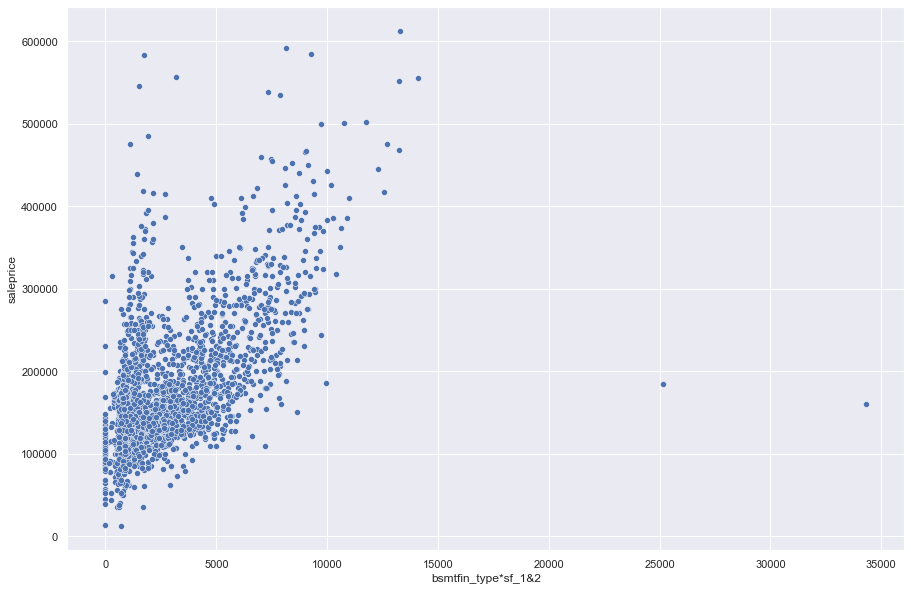

In [161]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=house_sdf, x = 'bsmtfin_type*sf_1&2', y='saleprice')
plt.show();


Box - House age vs saleprice

Comment:

* Saleprice decrease with age of house. New house command higher price

Text(0.5, 1.0, 'House Age vs Saleprice')

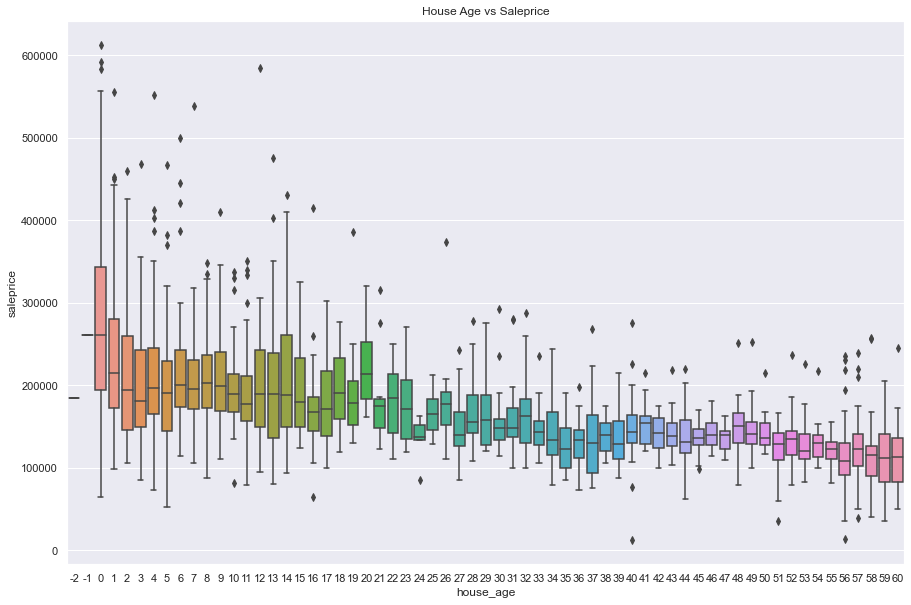

In [162]:
plt.figure(figsize=(15,10))
sns.boxplot(data=house_sdf, x = 'house_age', y='saleprice')
plt.title('House Age vs Saleprice')

Scat - Total floor surface area against sale price

Comment:

* Sale price increase with the total floor surface area

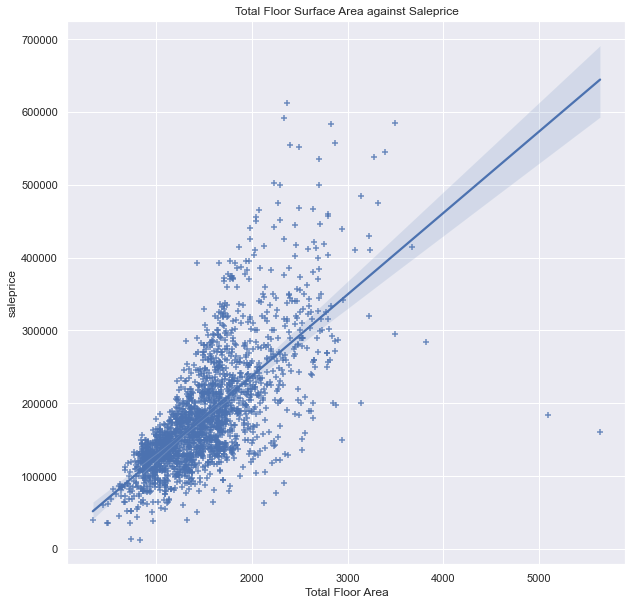

In [163]:
plt.figure(figsize=(10,10))
sns.regplot(data=house_sdf, x = 'ttl_flr_sf', y='saleprice',marker='+')
plt.title('Total Floor Surface Area against Saleprice')
plt.xlabel('Total Floor Area')
plt.show();

Scat - Porch total surface area against saleprice

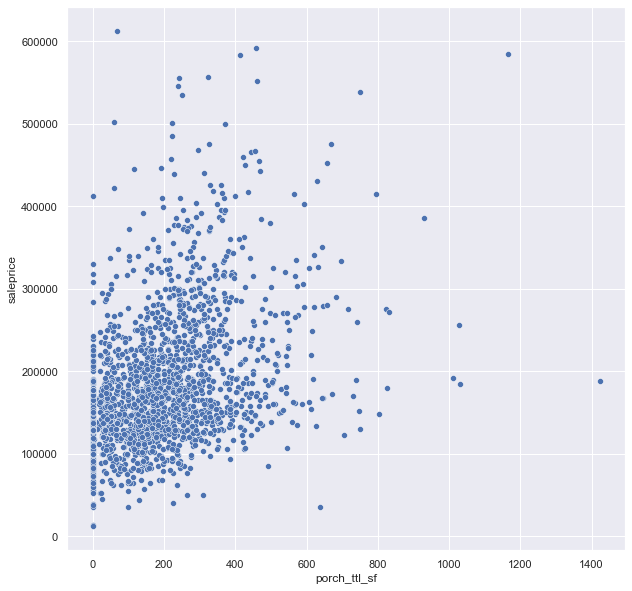

In [164]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=house_sdf, x = 'porch_ttl_sf', y='saleprice')
plt.show();

Box - Overall score (quality * condition) against saleprice

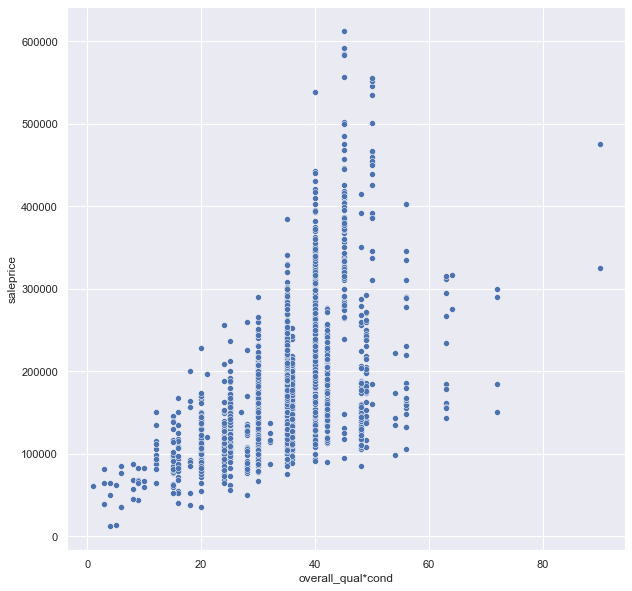

In [165]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=house_sdf, x = 'overall_qual*cond', y='saleprice')
plt.show();

Box - Total bath (incl. full and half bath (abv and basement)) against saleprice

Comment:

* Total number of bathroom has positive effect on saleprice

Text(0.5, 0, 'Total bathroom')

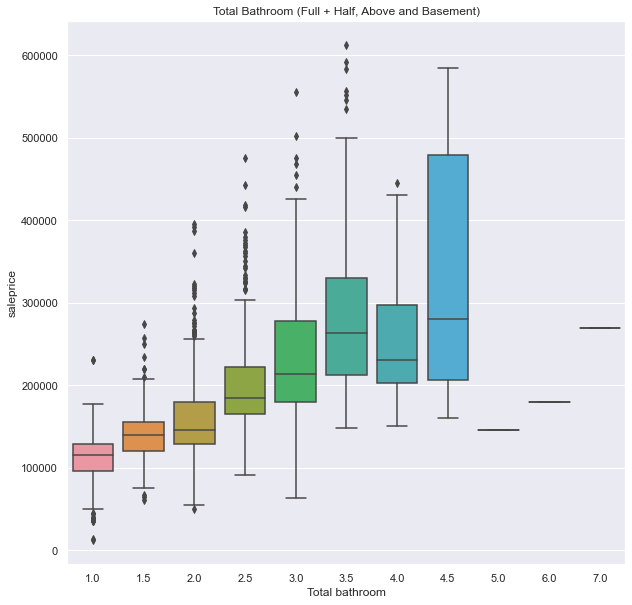

In [166]:
plt.figure(figsize=(10,10))
sns.boxplot(data=house_sdf, x = 'ttl_bath', y='saleprice')
plt.title('Total Bathroom (Full + Half, Above and Basement)')
plt.xlabel('Total bathroom')

Box - External Quality*Condition VS Saleprice

Comment:

* The sale price increases with the external quality and condition

Text(0.5, 1.0, 'External Quality and Condition VS Saleprice')

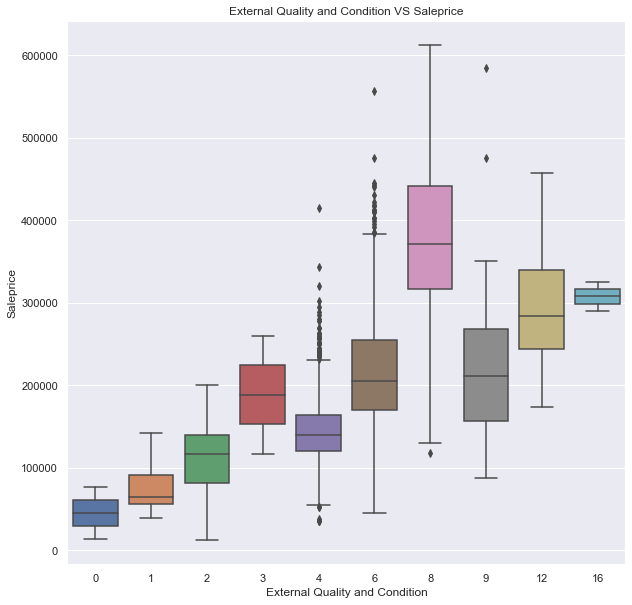

In [167]:
plt.figure(figsize=(10,10))
sns.boxplot(data=house_sdf, x = 'ext_qual*cond', y='saleprice')
plt.xlabel('External Quality and Condition')
plt.ylabel('Saleprice')
plt.title('External Quality and Condition VS Saleprice')

Box - Basement quality vs Saleprice

Comment:

* Basement quality positively affect the sale price

Text(0.5, 1.0, 'Basement Quality and Condition VS Saleprice')

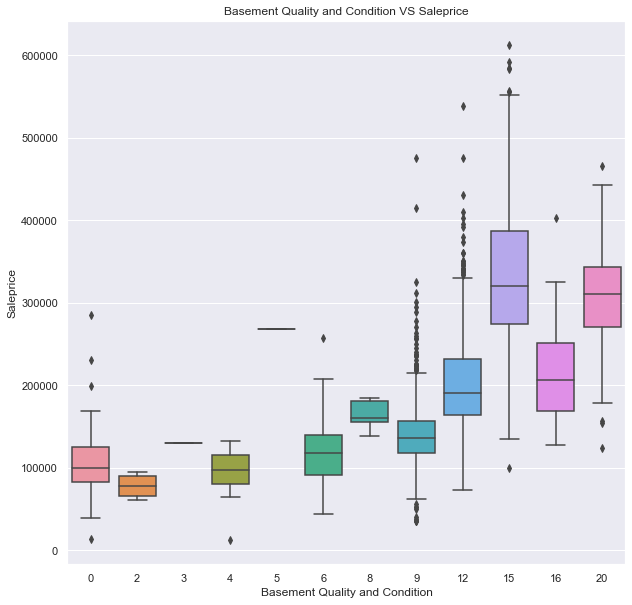

In [168]:
plt.figure(figsize=(10,10))
sns.boxplot(data=house_sdf, x = 'bsmt_qual*cond', y='saleprice')
plt.xlabel('Basement Quality and Condition')
plt.ylabel('Saleprice')
plt.title('Basement Quality and Condition VS Saleprice')

Scat - Total Basement Area VS Saleprice

Comment:

* Price increase with total basement area

Text(0.5, 1.0, 'Total Basement Area VS Saleprice')

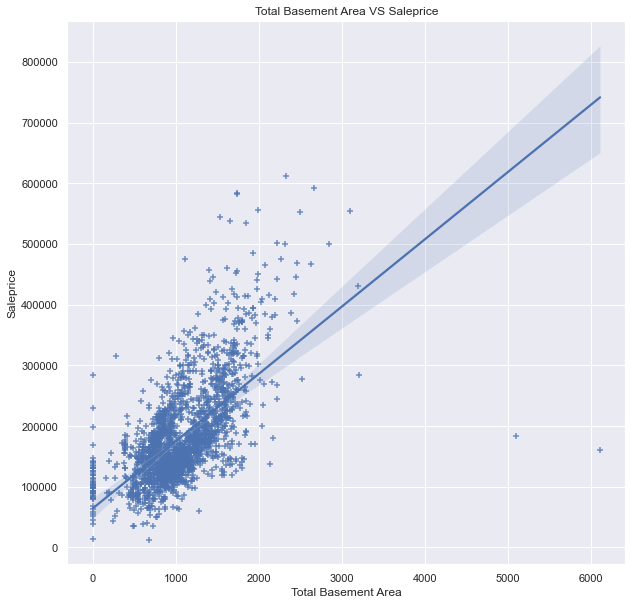

In [169]:
plt.figure(figsize=(10,10))
sns.regplot(data=house_df, x = 'total_bsmt_sf', y='saleprice', marker = '+')
plt.xlabel('Total Basement Area')
plt.ylabel('Saleprice')
plt.title('Total Basement Area VS Saleprice')

## 2.8 Hypothesis Testing

In [170]:
# repeating the same feature-response assignment from defined dataframe above

hypo_test_X_sdf = house_sdf.drop("saleprice", axis=1) # dropping db as that'll be response
hypo_test_X_sdf = hypo_test_X_sdf._get_numeric_data()
hypo_test_X_sdf = sm.add_constant(hypo_test_X_sdf)
hypo_test_y_sdf  = house_sdf["saleprice"]._get_numeric_data()


In [171]:
results = sm.OLS(hypo_test_y_sdf, hypo_test_X_sdf).fit() # OLS: ordinary least squares, fits a simple linear reg model with OLS

results.summary() # displays various linear regression model stats

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     337.5
Date:                Mon, 13 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:27:56   Log-Likelihood:                -24123.
No. Observations:                2051   AIC:                         4.831e+04
Df Residuals:                    2017   BIC:                         4.851e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -7.86e+05   8.53e+04     -9.214      0.000   -9.53e+05   -6.19e+05
id                      0.9167      0.850      1.078      0.281      -0.751       2.584
pid                 -1.551e-05   4.16e-06     -3.725      0.000   -2.37e-05   -7.34e-06
ms_subclass          -152.3120     20.485     -7.435      0.000    -192.485    -112.139
lot_frontage           53.2621     23.290      2.287      0.022       7.587      98.937
lot_area                0.2991      0.123      2.437      0.015       0.058       0.540
lot_shape            -949.8681   1406.851     -0.675      0.500   -3708.901    1809.165
house_style          2381.7775    492.169      4.839      0.000    1416.564    3346.990
year_built            375.1415     42.905      8.744      0.000     290.999     459.284
mas_vnr_area           37.5402      4.750      7.904      0.000      28.226      46.855
bsmt_exposure        6717.9072    832.432      8.070      0.000    5085.390    8350.424
total_bsmt_sf          -3.0270      2.919     -1.037      0.300      -8.752       2.698
heating_qc           2755.0200    918.915      2.998      0.003     952.898    4557.142
gr_liv_area            20.7830     28.083      0.740      0.459     -34.292      75.858
bedroom_abvgr       -5360.6249   1255.554     -4.270      0.000   -7822.944   -2898.306
totrms_abvgrd        2451.4921    919.084      2.667      0.008     649.040    4253.944
garage_yr_blt         -11.1559      3.501     -3.186      0.001     -18.023      -4.289
garage_finish        2449.4248   1157.007      2.117      0.034     180.372    4718.478
garage_cars          6669.2812   2328.785      2.864      0.004    2102.206    1.12e+04
garage_area            24.5489      7.923      3.098      0.002       9.011      40.087
pool_area             -92.3205     18.970     -4.867      0.000    -129.524     -55.117
misc_val              -12.4553      1.250     -9.965      0.000     -14.906     -10.004
mo_sold               127.3476    256.949      0.496      0.620    -376.566     631.261
bsmt_qual*cond       1892.4363    350.534      5.399      0.000    1204.990    2579.883
bsmtfin_type*sf_1&2     3.0326      0.480      6.316      0.000       2.091       3.974
ttl_flr_sf             30.0344     28.252      1.063      0.288     -25.372      85.441
ttl_bath             1968.8800   1476.941      1.333      0.183    -927.609    4865.369
kitchen_ttl_qual     7734.2379   1307.920      5.913      0.000    5169.222    1.03e+04
fireplace_ttl_qual   2594.4328    381.968      6.792      0.000    1845.340    3343.526
porch_ttl_sf           21.4332      5.059      4.236      0.000      11.511      31.355
overall_qual*cond    1370.4016    105.073     13.042      0.000    1164.339    1576.465
ext_qual*cond        2862.6166    649.486      4.408      0.000    1588.884    4136.349
gar

Comment: 
* Total Basement Floor has a P-value higher than 0.05, however, I believe saleprice is undoubtly affected by the total livable floor area
* Ground living area also have a P-value higher than 0.05. This feature will not be dropped.
* House age has a Pvalue larger than 0.05, but I also believe that the age of the house will also affects the sale price because the condition of the house will deteriorate across time.
* Lot shape, month sold, and garage quality & condition will be dropped

## 2.9 Recursive Feature Elimination (revisit)

In [172]:
lr = LinearRegression()
rfe1 = RFE(lr, n_features_to_select=10, step=1)
rfe1_sdf = house_sdf.drop(columns=['saleprice'])._get_numeric_data()
selector = rfe1.fit(rfe1_sdf,house_sdf['saleprice'])
selectedFeatures = list(rfe1_sdf.columns[selector.support_])
selectedFeatures

['lot_shape',
 'bsmt_exposure',
 'heating_qc',
 'totrms_abvgrd',
 'garage_finish',
 'garage_cars',
 'ttl_bath',
 'kitchen_ttl_qual',
 'fireplace_ttl_qual',
 'ext_qual*cond']

## 2.10 Drop Features

Comment:

Features and reason for dropping:

1. Ground living area was dropped as it exhibit similar patterns as total floor area feature

2. Total Rooms and bedroom above ground are dropped as it is generalized by total floor area feature

3. Garage cars feature is dropped in favour of garage area

4. Other features that were dropped shows insignificant impact on the saleprices based on RFE and correlation



In [173]:
# Drop unwanted columns
print(f'Train data shape before dropping columns {house_sdf.shape}')
print(f'Test data shape before dropping columns {house_test_sdf.shape}')

house_sdf = house_sdf.drop(columns=['pid','year_built','garage_cars', 'misc_feature', 'garage_yr_blt','pool_area','pool_qc','mo_sold',
                                    'street','alley','land_contour','utilities','land_slope','condition_1','condition_2','roof_matl','heating',
                                    'central_air','electrical','functional','paved_drive','sale_type','exterior_1st','exterior_2nd'])
house_sdf = house_sdf.drop(columns=['lot_frontage','lot_shape','bedroom_abvgr','totrms_abvgrd', 'gr_liv_area'])

house_test_sdf = house_test_sdf.drop(columns=['pid','year_built','garage_cars', 'misc_feature', 'garage_yr_blt','pool_area','pool_qc','mo_sold',
                                    'street','alley','land_contour','utilities','land_slope','condition_1','condition_2','roof_matl',
                                    'heating','central_air','electrical','functional','paved_drive','sale_type','exterior_1st','exterior_2nd'])
house_test_sdf = house_test_sdf.drop(columns=['lot_frontage','lot_shape','bedroom_abvgr','totrms_abvgrd', 'gr_liv_area'])

print(f'Train data shape after second feature filter: {house_sdf.shape}')
print(f'Test data shape after second feature filter: {house_test_sdf.shape}')

Train data shape before dropping columns (2051, 61)
Test data shape before dropping columns (878, 60)
Train data shape after second feature filter: (2051, 32)
Test data shape after second feature filter: (878, 31)


## 2.11 One-Hot Encoder

In [174]:
# Convert categorical OHE

ohe_features = ['MS SubClass',
                'MS Zoning',
                'Lot Config',
                'Neighborhood',
                'Bldg Type',
                'Roof Style',
                'Mas Vnr Type',
                'Foundation',
                'Garage Type',
                'Fence']

# replace old name with new naming convention
ohe_features = [feature.lower().replace(' ', '_') for feature in ohe_features]

if len(list(set(set(ohe_features).difference(house_sdf.columns)))) != 0:
    print(f'Difference detected: {list(set(set(ohe_features).difference(house_sdf.columns)))}')
    
if len(list(set(set(ohe_features).difference(house_test_sdf.columns)))) != 0:
    print(f'Difference detected: {list(set(set(ohe_features).difference(house_test_sdf.columns)))}')



In [175]:
combined_ohe_sdf = pd.concat([house_sdf[ohe_features], house_test_sdf[ohe_features]])
ohe = OneHotEncoder(drop="first")
ohe = ohe.fit(combined_ohe_sdf)
transformed = ohe.transform(house_sdf[ohe_features])
transformed.toarray()
ohe_cols_train = pd.DataFrame(transformed.toarray(), columns = ohe.get_feature_names_out())
ohe_cols_train.head()


,ms_subclass_30,ms_subclass_40,ms_subclass_45,ms_subclass_50,ms_subclass_60,ms_subclass_70,ms_subclass_75,ms_subclass_80,ms_subclass_85,ms_subclass_90,...,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [176]:
print(f'Train data, before OHE: {house_sdf.shape}')
house_sdf = pd.merge(house_sdf,ohe_cols_train,left_index=True, right_index=True)
print(f'Train data, after OHE: {house_sdf.shape}')
house_sdf = house_sdf.drop(columns=ohe_features)
print(f'Train data, after drop original column: {house_sdf.shape}')

Train data, before OHE: (2051, 32)
Train data, after OHE: (2051, 112)
Train data, after drop original column: (2051, 102)


In [177]:
#combined_df_ohe = pd.concat([house_df[ohe_features], house_test_df[ohe_features]])
ohe = OneHotEncoder(drop="first")
ohe = ohe.fit(combined_ohe_sdf)
transformed = ohe.transform(house_test_sdf[ohe_features])
transformed.toarray()
ohe_cols_train = pd.DataFrame(transformed.toarray(), columns = ohe.get_feature_names_out())
ohe_cols_train.head()

,ms_subclass_30,ms_subclass_40,ms_subclass_45,ms_subclass_50,ms_subclass_60,ms_subclass_70,ms_subclass_75,ms_subclass_80,ms_subclass_85,ms_subclass_90,...,garage_type_Attchd,garage_type_Basment,garage_type_BuiltIn,garage_type_CarPort,garage_type_Detchd,garage_type_NA,fence_GdWo,fence_MnPrv,fence_MnWw,fence_NA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [178]:
print(f'Test data, before OHE: {house_test_sdf.shape}')
house_test_sdf = pd.merge(house_test_sdf,ohe_cols_train,left_index=True, right_index=True)
print(f'Test data, after OHE: {house_test_sdf.shape}')
house_test_sdf = house_test_sdf.drop(columns=ohe_features)
print(f'Test data, after drop original column: {house_test_sdf.shape}')

Test data, before OHE: (878, 31)
Test data, after OHE: (878, 111)
Test data, after drop original column: (878, 101)


# **SECTION 3 - Modeling**
---

## 3.1 Model Prep

### 3.1.1 Data checking

In [179]:
house_sdf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 102 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    2051 non-null   int64  
 1    lot_area              2051 non-null   int64  
 2    house_style           2051 non-null   int32  
 3    mas_vnr_area          2051 non-null   float64
 4    bsmt_exposure         2051 non-null   int32  
 5    total_bsmt_sf         2051 non-null   float64
 6    heating_qc            2051 non-null   int32  
 7    garage_finish         2051 non-null   int32  
 8    garage_area           2051 non-null   float64
 9    misc_val              2051 non-null   int64  
 10   saleprice             2051 non-null   int64  
 11   bsmt_qual*cond        2051 non-null   int32  
 12   bsmtfin_type*sf_1&2   2051 non-null   float64
 13   ttl_flr_sf            2051 non-null   float64
 14   ttl_bath              2051 non-null   float64
 15   ki

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\1533423799.py:1: FutureWarning:

null_counts is deprecated. Use show_counts instead



In [180]:
house_test_sdf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 101 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    878 non-null    int64  
 1    lot_area              878 non-null    int64  
 2    house_style           878 non-null    int32  
 3    mas_vnr_area          878 non-null    float64
 4    bsmt_exposure         878 non-null    int32  
 5    total_bsmt_sf         878 non-null    int64  
 6    heating_qc            878 non-null    int32  
 7    garage_finish         878 non-null    int32  
 8    garage_area           878 non-null    int64  
 9    misc_val              878 non-null    int64  
 10   bsmt_qual*cond        878 non-null    int32  
 11   bsmtfin_type*sf_1&2   878 non-null    int64  
 12   ttl_flr_sf            878 non-null    float64
 13   ttl_bath              878 non-null    float64
 14   kitchen_ttl_qual      878 non-null    int64  
 15   fire

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\3009144045.py:1: FutureWarning:

null_counts is deprecated. Use show_counts instead



In [181]:
print(house_sdf.select_dtypes(include=['object']).columns)
print(house_test_sdf.select_dtypes(include=['object']).columns)

Index([], dtype='object')
Index([], dtype='object')


In [182]:
features = [col for col in house_sdf._get_numeric_data().columns if col != 'saleprice' and col != 'id']
print(f'Sum of numeric features: {len(features)}')
features

Sum of numeric features: 100


['lot_area',
 'house_style',
 'mas_vnr_area',
 'bsmt_exposure',
 'total_bsmt_sf',
 'heating_qc',
 'garage_finish',
 'garage_area',
 'misc_val',
 'bsmt_qual*cond',
 'bsmtfin_type*sf_1&2',
 'ttl_flr_sf',
 'ttl_bath',
 'kitchen_ttl_qual',
 'fireplace_ttl_qual',
 'porch_ttl_sf',
 'overall_qual*cond',
 'ext_qual*cond',
 'garage_qual*cond',
 'house_age',
 'ms_subclass_30',
 'ms_subclass_40',
 'ms_subclass_45',
 'ms_subclass_50',
 'ms_subclass_60',
 'ms_subclass_70',
 'ms_subclass_75',
 'ms_subclass_80',
 'ms_subclass_85',
 'ms_subclass_90',
 'ms_subclass_120',
 'ms_subclass_150',
 'ms_subclass_160',
 'ms_subclass_180',
 'ms_subclass_190',
 'ms_zoning_C (all)',
 'ms_zoning_FV',
 'ms_zoning_I (all)',
 'ms_zoning_RH',
 'ms_zoning_RL',
 'ms_zoning_RM',
 'lot_config_CulDSac',
 'lot_config_FR2',
 'lot_config_FR3',
 'lot_config_Inside',
 'neighborhood_Blueste',
 'neighborhood_BrDale',
 'neighborhood_BrkSide',
 'neighborhood_ClearCr',
 'neighborhood_CollgCr',
 'neighborhood_Crawfor',
 'neighborhood_

### 3.1.2 Split data into (X) matrix and target vector (y)

In [183]:
# Split train data and response data to X matrix and y vector
X = house_sdf[features]
y = house_sdf['saleprice']

In [184]:
X.isnull().sum().sort_values(ascending=False).head(2)

lot_area                0
neighborhood_NridgHt    0
dtype: int64

In [185]:
y.sort_values(ascending=True)

1628     12789
183      13100
1309     34900
1292     35000
1518     35311
         ...  
151     556581
1796    582933
1692    584500
1964    591587
1671    611657
Name: saleprice, Length: 2051, dtype: int64

### 3.1.3 Train/test split

In [186]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42)

### 3.1.4 Scaling

In [187]:
X_train.isnull().sum()

lot_area          0
house_style       0
mas_vnr_area      0
bsmt_exposure     0
total_bsmt_sf     0
                 ..
garage_type_NA    0
fence_GdWo        0
fence_MnPrv       0
fence_MnWw        0
fence_NA          0
Length: 100, dtype: int64

In [188]:
y_train

532     167300
415     219000
273     129000
1460    328000
250     290000
         ...  
1724    319500
1095    139000
1130    181000
1294    106000
860     235000
Name: saleprice, Length: 1538, dtype: int64

Standard scaler was not used because the data involves categorical data which only hovers around 0 to 1. For that matter, MinMaxScaler is much more suitable transformer of the data as we can set the range to be within 0 to 1.

In [189]:
#ss = StandardScaler()
mc = MinMaxScaler(feature_range=(0,1))
ss_X_train = mc.fit_transform(X_train)# the same as doing ss.fit(X_train), then X_train=ss.transform(X_train)
ss_X_validation = mc.transform(X_validation)

### 3.1.5 Instantiate models

In [190]:
l_alphas = np.logspace(-3, 0, 100)
alphas = np.logspace(0,5,100)
cv = 5

In [191]:
lr = LinearRegression()
lasso = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
ridge = RidgeCV(alphas = alphas)

### 3.1.6 Cross validation

In [192]:
# Method 1: Linear Regression
lr_scores = cross_val_score(lr, X_train, y_train, cv=cv)
print(f'LR cross-validation score: {lr_scores.mean()}')

# Method 2: Lasso Regression (L1)
lasso_scores = cross_val_score(lasso, ss_X_train, y_train, cv=cv)
print(f'Lasso cross-validation score: {lasso_scores.mean()}')

# Method 3: Ridge Regression (L2)
ridge_scores = cross_val_score(ridge, ss_X_train, y_train, cv=cv)
print(f'Ridge cross-validation score: {ridge_scores.mean()}')

LR cross-validation score: 0.8178037891436645
Lasso cross-validation score: 0.8185527610645018
Ridge cross-validation score: 0.8326335861342494


## 3.2 Model Fitting and Evaluation

### 3.2.1 Linear Model

In [193]:
lr.fit(X_train,y_train)
print(f'{lr.score(X_train, y_train)}')
y_pred_lr = lr.predict(X_validation) # making predictions on testing set
print(f'{r2_score(y_validation, y_pred_lr)}')


0.8774443294438994
0.8913372585290038


### 3.2.2 Lasso Model

In [194]:
lasso.fit(ss_X_train, y_train)
print(f'{lasso.score(ss_X_train, y_train)}')
y_pred_lasso = lasso.predict(ss_X_validation) # making predictions on testing set
print(f'{r2_score(y_validation, y_pred_lasso)}')

0.8774307208661154
0.8915164507527062


In [195]:
lasso.alpha_

1.0

### 3.2.3 Ridge Model

In [196]:
ridge.fit(ss_X_train, y_train)
print(f'{ridge.score(ss_X_train, y_train)}')
y_pred_ridge = ridge.predict(ss_X_validation) # making predictions on testing set
print(f'{r2_score(y_validation, y_pred_ridge)}')

0.8677200244208493
0.8823752867362186


### 3.2.4 Root Mean Square Error

In [197]:
print(f'RMSE (Linear) = {mean_squared_error(y_validation,y_pred_lr,squared =False)}')
print(f'RMSE (Lasso) = {mean_squared_error(y_validation,y_pred_lasso,squared =False)}')
print(f'RMSE (Ridge) = {mean_squared_error(y_validation,y_pred_ridge,squared =False)}')


RMSE (Linear) = 25830.05845706312
RMSE (Lasso) = 25808.75191113058
RMSE (Ridge) = 26874.12600132977


### Visual Check

Reg - Real vs Predicted Saleprice (Linear Reg)

In [198]:
y_pred_sdf = pd.DataFrame(y_validation)
y_pred_sdf['y_pred_lr'] = y_pred_lr
y_pred_sdf['y_pred_lasso'] = y_pred_lasso
y_pred_sdf['y_pred_ridge'] = y_pred_ridge
y_pred_sdf.head()

,saleprice,y_pred_lr,y_pred_lasso,y_pred_ridge
1124,132500,119423.723524,119360.338555,118860.035035
188,226000,212343.125032,212365.284475,213090.818935
1727,250000,323167.775697,323194.756606,327140.359191
1658,128000,112590.104379,112784.149584,117109.999634
1424,203160,202544.301657,202593.775757,203151.504641


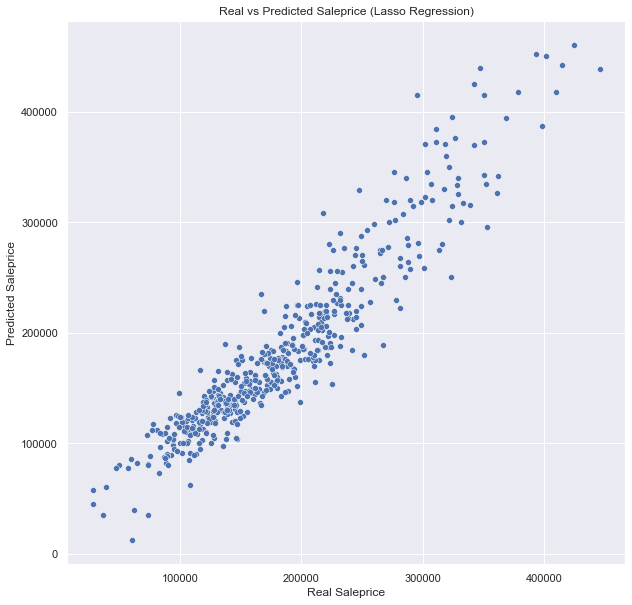

In [199]:
plt.figure(figsize=(10,10))
sns.scatterplot(data = y_pred_sdf,x='y_pred_lasso', y='saleprice')
plt.title('Real vs Predicted Saleprice (Lasso Regression)')
plt.xlabel('Real Saleprice')
plt.ylabel('Predicted Saleprice')
plt.show();


# SECTION 4 - Prediction

## 4.1 Run prediction

Based on the result shown by the R-squared and Root Mean Square Error, Lasso regression displays the best result. Therefore, Lasso Regression was used to run the prediciton on the test data.

In [200]:
def predict_data(df_train,df_test,l_alphas,alphas):
    features_train = [col for col in df_train._get_numeric_data().columns if col != 'saleprice' and col != 'id']
    features_test = [col for col in df_test._get_numeric_data().columns if col != 'saleprice' and col != 'id']
    X = df_train[features_train]
    y = df_train['saleprice']
    X_test = df_test[features_test]

    #------------------------------------------------------------------------------------#

    # Scaling (Transformer)
    #ss_test = StandardScaler()
    mc_test = MinMaxScaler(feature_range=(0,1))
    ss_train_X = mc_test.fit_transform(X)
    ss_test_X = mc_test.transform(X_test)
    
    # Model Prep
    lr_test = LinearRegression()
    lasso_test = LassoCV(alphas=l_alphas, cv=5, max_iter=50000)
    ridge_test = RidgeCV(alphas = alphas)

    # Linear Regression (not using transformer)
    lr_test.fit(X,y)
    lr_test_score = lr_test.score(X,y)
    y_test_pred_lr = lr_test.predict(X_test) # making predictions on testing set
    lr_test_coef = lr_test.coef_
    # Lasso Regression (scaling method)
    lasso_test.fit(ss_train_X,y)
    lasso_test_score = lasso_test.score(ss_train_X,y)
    y_test_pred_lasso = lasso_test.predict(ss_test_X) # making predictions on testing set
    lasso_test_coef = lasso_test.coef_
    # Lasso Regression (scaling method)
    ridge_test.fit(ss_train_X,y)
    ridge_test_score = ridge_test.score(ss_train_X,y)
    y_test_pred_ridge = ridge_test.predict(ss_test_X) # making predictions on testing set
    ridge_test_coef = ridge_test.coef_   
    #------------------------------------------------------------------------------------#

    # Submission

    # Adding Id column
    result_lr_pred_df = df_test[['id']]
    result_lasso_pred_df = df_test[['id']]
    result_ridge_pred_df = df_test[['id']]
    
    # Adding Saleprice columns
    result_lr_pred_df.loc[:,['SalePrice']] = y_test_pred_lr
    result_lasso_pred_df.loc[:,['SalePrice']] = y_test_pred_lasso
    result_ridge_pred_df.loc[:,['SalePrice']] = y_test_pred_ridge

    # Sorting data
    result_lr_pred_df = result_lr_pred_df.sort_values(['id'],ascending= True)
    result_lasso_pred_df = result_lasso_pred_df.sort_values(['id'],ascending= True)
    result_ridge_pred_df = result_ridge_pred_df.sort_values(['id'],ascending= True)

    # Saving to csv
    result_lr_pred_df.to_csv('./datasets/result_lr.csv', index=False)
    result_lasso_pred_df.to_csv('./datasets/result_lasso.csv', index=False)
    result_ridge_pred_df.to_csv('./datasets/result_ridge.csv', index=False)

    #print(f'cv: {cv}\nalphas: {alphas}\nn_alphas: {n_alphas}\n')
    print(f'Best alpha for Lasso regression {lasso_test.alpha_}')
    print(f'Sum of numeric features (Train data): {len(features_train)}')
    print(f'Sum of numeric features (Test data): {len(features_test)}')
    print(f'"result_lr_pred_df" shape: {result_lr_pred_df.shape}')
    print(f'Linear regression score: {lr_test_score}')
    print(f'"result_lasso_pred_df" shape: {result_lasso_pred_df.shape}')
    print(f'Lasso regression score: {lasso_test_score}')
    print(f'"result_ridge_pred_df" shape: {result_ridge_pred_df.shape}')
    print(f'Ridge regression score: {ridge_test_score}')
    return lr_test_coef , lasso_test_coef, ridge_test_coef #result_lr_pred_df, result_lasso_pred_df, result_ridge_pred_df

In [201]:
lr_coef, lasso_coef , ridge_coef = predict_data(house_sdf,house_test_sdf,l_alphas,alphas)

Best alpha for Lasso regression 1.0
Sum of numeric features (Train data): 100
Sum of numeric features (Test data): 100
"result_lr_pred_df" shape: (878, 2)
Linear regression score: 0.8834842192920691
"result_lasso_pred_df" shape: (878, 2)
Lasso regression score: 0.8834717408879386
"result_ridge_pred_df" shape: (878, 2)
Ridge regression score: 0.876988825031451


C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\305392611.py:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\305392611.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Tham Shi Yi\AppData\Local\Temp\ipykernel_8540\305392611.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

## 4.2 Top coefficient features

Comment:

The features with highest coefficient is the total floor area.

In [202]:
coef_df = pd.DataFrame(abs(lasso_coef), index = house_test_sdf.drop(columns=['id']).columns, columns = ['coefficient'] )
coef_df.sort_values(['coefficient'],ascending=False).head(10)

,coefficient
ttl_flr_sf,224278.721659
misc_val,164785.048981
neighborhood_GrnHill,123858.134649
overall_qual*cond,98237.974361
bsmtfin_type*sf_1&2,90677.367628
neighborhood_StoneBr,56898.472733
ms_subclass_150,51358.912274
mas_vnr_area,50839.021229
kitchen_ttl_qual,46643.217905
garage_area,44135.815161


# SECTION 5 - Conclusion
---

1. The predicted model have a root mean squared error of 25808.75191113058.

2. The lasso regression model was able to reach a score of 22831.45419 in the Kaggle competition.

3. The quality and space of the property plays a huge role in the sale price. The increase in the quality means that the material used are also of a higher quality, this is intuitively true with the increase of material used and also the quality of the material will directly impact the price. Since the land is limited, as the livable space increases, the sale price increases.

4. The neighborhood or generally the location of the property affects the sale price.

5. With the increase in quality and total livable area, the price increases.